In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from bs4 import BeautifulSoup as bs
import requests
import warnings
import json
import datetime as dt
warnings.filterwarnings('ignore')
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from genderize import Genderize
from collections import Counter
import string
import nltk

L'étude se base sur les données du site Internet suivant :https://scomedy.com

### <span style="color: #030aa4">Extraction des données</span>

In [2]:
quote_list = []
comedian_list = []
view_list = []
theme_list = []
page_list = []
url_list = []

NUM_PAGES = 1260

for i in np.arange(1,NUM_PAGES):
  
    url = 'https://scomedy.com/quotes?page=' + str(i) #Affichage de toutes les pages du site scomedy
    source = requests.get(url) #Reqête de chaque url
    soup = bs(source.text, 'lxml')
    
    quotes = soup.find_all('div', {'class':'quote'})
    

    for quote in quotes:
        
        citation = quote.find('p').text
        quote_list.append(citation)
        
        comedian = quote.find('div',class_='comedian').text.split("\xa0")[1].split('\n')[0]
        comedian_list.append(comedian)
        
        view = int(quote.find('span',class_='views').text.split(" ")[1])
        view_list.append(view)
        
        tags_for_this_quote = []
        if quote.find('li'): 
        
            for element in quote.find_all('li'):
                theme = element.text.split("#")[1]
                tags_for_this_quote.append(theme)           
        else:
            tags_for_this_quote= None
            
        theme_list.append(tags_for_this_quote)
        
        page = i
        page_list.append(page)
        
        #url_list.append(url)
        
dict_quote ={'citation':quote_list,'auteur':comedian_list,'nbre_vues':view_list,'theme':theme_list,'page_site':page_list}
Quote_df = pd.DataFrame(dict_quote)
Quote_df

citation            auteur  \
0      Well, birthdays are merely symbolic of how ano...    Jerry Seinfeld   
1      My perfect date night: I pick you up. In my Ki...       Aziz Ansari   
2      I mean, they don't grade fathers. But if your ...        Chris Rock   
3      Jack and Jill went up the hill Both with a buc...  Andrew Dice Clay   
4      “Money doesn’t buy happiness.” Uh, do you live...       Daniel Tosh   
...                                                  ...               ...   
18868  A couple weeks ago I was on the street and I s...    Demetri Martin   
18869  Whenever I see an autobiography for sale in th...    Demetri Martin   
18870  I saw a door that said exit only. So I entered...    Demetri Martin   
18871  I bought a dictionary. First thing I did was, ...    Demetri Martin   
18872  I was seeing this girl and she wanted to get m...    Demetri Martin   

       nbre_vues                          theme  page_site  
0           1682                     [birthday]          1  
1           1466  [danger, dating, restaurants]          1  
2           1329                           None          1  
3           1184                           None          1  
4           1060                    [happiness]          1  
...          ...                            ...        ...  
18868          4                           None       1258  
18869          4                           None       1258  
18870          4                           None       1259  
18871          4                           None       1259  
18872          4                           None       1259  

[18873 rows x 5 columns]

In [3]:
quote_df = Quote_df.copy()

### <span style="color: #030aa4">Brève description du jeu de données</span>

Le jeu de données "quote_df" est composé de 5 colonnes :
- citation
- auteur
- nbre_vues : le site scomedy.com indique le nombre de vues pour chaque citation
- theme : le site scomedy.com renseigne le ou les thèmes abordés pour chaque citation (premier constat : certaines citations n'ont pas de thèmes)
- page_site : numéro de la page du site sur laquelle est écrite la citation

### <span style="color: #030aa4">Vérification des données</span>

In [4]:
#Identification des doublons
doublons = quote_df.loc[quote_df.citation.duplicated(keep=False), :]

pourcentageDoublons = round((len(doublons)/len(quote_df))*100,2)

print("Il y a",len(doublons),"doublons.")
print("Soit",pourcentageDoublons,"% des données.")

Il y a 228 doublons.
Soit 1.21 % des données.


#### Identification des mêmes citations avec un auteur différent : 

In [5]:
doublons = doublons.sort_values(by='citation')

Doublons_Auteur = doublons[~doublons.duplicated(['citation', 'auteur'],keep=False)]

print("Parmi les doublons, il y a",int(len(Doublons_Auteur)/2),"citations pour lesquelles il y a deux auteurs.")

Parmi les doublons, il y a 16 citations pour lesquelles il y a deux auteurs.


In [6]:
Doublons_Auteur.head(6)

citation         auteur  \
2883   Do infants enjoy infancy as much as adults enj...  George Carlin   
13414  Do infants enjoy infancy as much as adults enj...  Steven Wright   
15566  How to make a million dollars: First, get a mi...  Steven Wright   
64     How to make a million dollars: First, get a mi...   Steve Martin   
17285                I can levitate birds. No one cares.    Woody Allen   
2615                 I can levitate birds. No one cares.  Steven Wright   

       nbre_vues    theme  page_site  
2883          63    [age]        193  
13414         25     None        895  
15566         20     None       1038  
64           429  [money]          5  
17285         15     None       1153  
2615          65     None        175

Le numéro de la page nous permet de retrouver facilement les citations sur le site et de constater que les citations apparaissent bien plusieurs fois.

Les autres sources internet permettent de déduire que la paternité de la citation appartient toujours à celui qui a le plus grand nombre de vues.

Exemples :
- La citation 'Do infants enjoy infancy as much as adults enjoy adultery?' est bien attribuée à George Carlin (https://www.just-one-liners.com/do-infants-enjoy-infancy-as-much-as-adults-enjoy-adultery/).

- La citation 'How to make a million dollars: First, get a million dollars.' est bien attribuée à Steve Martin
(https://quotefancy.com/quote/971680/Steve-Martin-How-to-make-a-million-dollars-First-get-a-million-dollars).


Il faut donc supprimer les doublons de citation avec **le plus petit nombre de vues**.

In [7]:
Index_Faux_Auteur = Doublons_Auteur.sort_values('nbre_vues')\
                                   .drop_duplicates(subset='citation', keep='first')\
                                   .index\
                                   .tolist()

quote_df = quote_df.drop(Index_Faux_Auteur)

#### Identification des autres doublons :

In [8]:
doublons2 = quote_df.loc[quote_df.citation.duplicated(keep=False), :]

doublons2 = doublons2.sort_values(by='citation')

doublons2.head(6)

citation         auteur  \
14396  After they make styrofoam, what do they ship i...  Steven Wright   
14367  After they make styrofoam, what do they ship i...  Steven Wright   
11346  An actor's popularity is fleeting. His success...     Fred Allen   
7312   An actor's popularity is fleeting. His success...     Fred Allen   
17278  Anyone who has faith in humanity is probably a...  Richard Lewis   
16265  Anyone who has faith in humanity is probably a...  Richard Lewis   

       nbre_vues theme  page_site  
14396         23  None        960  
14367         23  None        958  
11346         30  None        757  
7312          40  None        488  
17278         15  None       1152  
16265         18  None       1085

Pour ces vrais duplicats, le **nombre de vues est différent**. Étant donné que ce nombre de vues correspond au nombre de clics sur le permalink de chaque citation, il convient donc d'**additionner le nombre de vues de chaque doublon**.

In [9]:
# Addition des nombre de vues pou chaque citation :
Total_View = doublons2.groupby(['citation','auteur'])['nbre_vues'].sum().reset_index()

# Récupération des thèmes, s'il est défini, de chacune des citations:
doublons2_theme = doublons2[~doublons2.theme.isnull()]
doublons2_theme = doublons2_theme.loc[ : ,('citation','theme')]\
                                 .drop_duplicates(subset='citation', keep='first')


# Jointure à gauche :
Citation_ViewTotal_Theme = pd.merge(Total_View,doublons2_theme, how='left')
Citation_ViewTotal_Theme = Citation_ViewTotal_Theme.replace({np.nan: None})

#Suppression des citations présentes plusieurs fois dans 'quote_df'
quote_df = quote_df.drop_duplicates(subset ='citation', keep=False)

#Suppression de la colonne 'page' (nous n'en aurons plus besoin):
quote_df = quote_df.drop(columns=['page_site'])

# Rajout des citations
quote_df = pd.concat([quote_df,Citation_ViewTotal_Theme], ignore_index=True)

quote_df.head(3)

citation          auteur  \
0  Well, birthdays are merely symbolic of how ano...  Jerry Seinfeld   
1  My perfect date night: I pick you up. In my Ki...     Aziz Ansari   
2  I mean, they don't grade fathers. But if your ...      Chris Rock   

   nbre_vues                          theme  
0       1682                     [birthday]  
1       1466  [danger, dating, restaurants]  
2       1329                           None

### <span style="color: #030aa4">Rajout de la colonne genre</span>

In [337]:
# Fonction créant une colonne avec le prénom de chaque auteur :
def first(string):
    parts = string.split(' ')
    first_part = parts[0] 
    return first_part
        
quote_df['prenom'] = quote_df['auteur'].apply(first)

# Création de la liste des prénoms : 
name = list(quote_df.prenom.unique())

# Interrogation de l'API https://pypi.org/project/Genderize/ :
gender_name = Genderize().get(name)

# Création de la liste 'gender' extraite de 'gender_name' :
gender = list(map(lambda gender: gender["gender"], gender_name))


# Création du dataset associant un genre à chaque prénom :
gender_df = pd.DataFrame(data={'prenom':name,'gender_API':gender})

# Jointure de gender_df et de quote_df :
quote_df = pd.merge(quote_df,gender_df)

quote_df.head(3)

citation          auteur  \
0  Well, birthdays are merely symbolic of how ano...  Jerry Seinfeld   
1  I was the best man to a wedding one time, that...  Jerry Seinfeld   
2  "Wait up!" That's what kids say. They don't sa...  Jerry Seinfeld   

   nbre_vues                          theme prenom gender_API  
0       1666                     [birthday]  Jerry       male  
1        472                           None  Jerry       male  
2        422  [kids, life, parents, future]  Jerry       male

**Vérification des résultats de l'API :**

In [338]:
def first(string):
    parts = string.split(' ')
    first_part = parts[0] 
    return first_part

Auteurs_df = pd.read_csv('Auteurs.csv',sep=';')

Genre = Auteurs_df.copy()

Genre['prenom'] = Genre['auteur'].apply(first)

Genre = Genre.drop(columns=['auteur','ethnie','religion','date_naissance','vivant','orientation_sexuelle'])

Genre = Genre.drop_duplicates()

Genre = Genre.rename(columns={'genre':'genre_manuel'})

df_Verif = pd.merge(Genre,gender_df)

df_Verif = df_Verif.loc[((df_Verif['genre_manuel'] == 'Homme') & 
                         (df_Verif['gender_API'] == 'female'))|
                         ((df_Verif['genre_manuel'] == 'Femme') &
                         (df_Verif['gender_API'] == 'male'))]

if len(df_Verif) == 0 :
    print('API ok')
else :
    print("Il y a",len(df_Verif),"erreurs, soit un mismatch de",round((len(df_Verif)/len(name))*100,2),"% :")
    print(" ")
    print(df_Verif)

Il y a 12 erreurs, soit un mismatch de 5.91 % :
 
    genre_manuel   prenom gender_API
26         Femme    Brett       male
33         Homme   Carrot     female
44         Homme     Dana     female
47         Homme     Dara     female
87         Homme    Henny     female
93         Homme   Jackie     female
103        Femme     Joan       male
114        Homme     Katt     female
158        Femme     Rene       male
178        Homme  Shelley     female
189        Femme      Tig       male
195        Homme    Tracy     female


Les prénoms tels que 'Jackie' sont bien féminins comme l'API nous l'informe, mais il se trouve que dans cette étude, il s'agit d'un homme. Cela pourrait très bien être un nom de scène prêtant volontairement à confusion (comme c'est le cas pour le chanteur Marylin Manson par exemple).

#### Jeu de données avec colonne 'genre' :

Pour la suite de l'étude, les informations pour chaque auteur au sujet de leur date de naissance, de leur état vivant ou non, de leur ethnie, leur religion et leur orientation sexuelle ont été rajoutées.

Lorsqu'aucune information liée à la religion n'existe, l'auteur est identifié comme athée.

In [10]:
Auteurs_df = pd.read_csv('Auteurs.csv',sep=';')

In [11]:
quote_df = pd.merge(quote_df,Auteurs_df)

#quote_df = quote_df.drop(columns=['prenom','gender_API'])

quote_df.head(3)

citation          auteur  \
0  Well, birthdays are merely symbolic of how ano...  Jerry Seinfeld   
1  I was the best man to a wedding one time, that...  Jerry Seinfeld   
2  "Wait up!" That's what kids say. They don't sa...  Jerry Seinfeld   

   nbre_vues                          theme  genre ethnie religion  \
0       1682                     [birthday]  Homme  blanc    athee   
1        480                           None  Homme  blanc    athee   
2        427  [kids, life, parents, future]  Homme  blanc    athee   

  date_naissance vivant orientation_sexuelle  
0     29-04-1954    Oui         heterosexuel  
1     29-04-1954    Oui         heterosexuel  
2     29-04-1954    Oui         heterosexuel

### <span style="color: #030aa4">Rajout des thèmes manquants</span>

In [12]:
themes_manquants = (len(quote_df[quote_df['theme'].isnull()])/len(quote_df))*100

print("Il y a",round(themes_manquants,2),"% des thèmes qui manquent.")

Il y a 71.57 % des thèmes qui manquent.


#### Thèmes existants :

In [13]:
quote_df_theme = quote_df.explode('theme')\
                         .loc[ : , ('theme','nbre_vues')]\
                         .groupby('theme').sum().reset_index()\

quote_df_theme.theme.unique()

array(['9/11', 'abortion', 'acceptance', 'accidents', 'addiction',
       'advertising', 'age', 'aggression', 'agnosticism', 'airports',
       'alaska', 'alcohol', 'animals', 'arguments', 'army', 'art',
       'asians', 'atheism', 'attitude', 'audience', 'babies', 'baseball',
       'basketball', 'beat', 'bible', 'birthday', 'boxing', 'brain',
       'business', 'california', 'cancer', 'care', 'cars', 'celebrities',
       'challenges', 'change', 'chicago', 'christmas', 'cocaine',
       'coffee', 'coma', 'comedians', 'common sense', 'complaints',
       'confidence', 'corporations', 'criticism', 'dancing', 'danger',
       'dating', 'death', 'decisions', 'democracy', 'desire', 'devil',
       'diapers', 'differences', 'dinosaurs', 'disney', 'divorce',
       'doctors', 'dogs', 'donald trump', 'douchebags', 'dreams',
       'driving', 'drugs', 'elvis presley', 'embarrassment', 'emotions',
       'ex girlfriend', 'experience', 'family', 'fishing', 'fitness',
       'florida', 'flowers'

#### Classement des thèmes existants :

In [14]:
quote_df_theme.sort_values(by='nbre_vues',ascending=False).head(50)

theme  nbre_vues
61            dogs       8236
49          dating       8046
136       new york       7582
158       religion       6825
28        business       6718
64          dreams       6612
149       politics       6286
65         driving       6081
84     girlfriends       6078
160    restaurants       6030
19        audience       5985
197          women       5860
37       christmas       5292
59         divorce       5286
126            men       5101
129          money       5036
89       happiness       4995
56     differences       4680
113           kids       4640
143        parents       4571
66           drugs       4449
27           brain       4342
25        birthday       4239
39          coffee       4214
165            sex       4173
47         dancing       4172
168        smoking       4130
81          future       4108
119           life       3916
167        sisters       3888
196           wife       3887
82            gays       3883
85            golf       3875
166          shoes       3872
93            hell       3870
86      government       3862
154      questions       3806
90            hate       3803
155         racism       3755
68   embarrassment       3667
195   white people       3604
51       decisions       3553
199          worth       3548
184     television       3487
146         people       3412
31            care       3359
183       teachers       3338
134   neighborhood       3338
60         doctors       3310
48          danger       3307

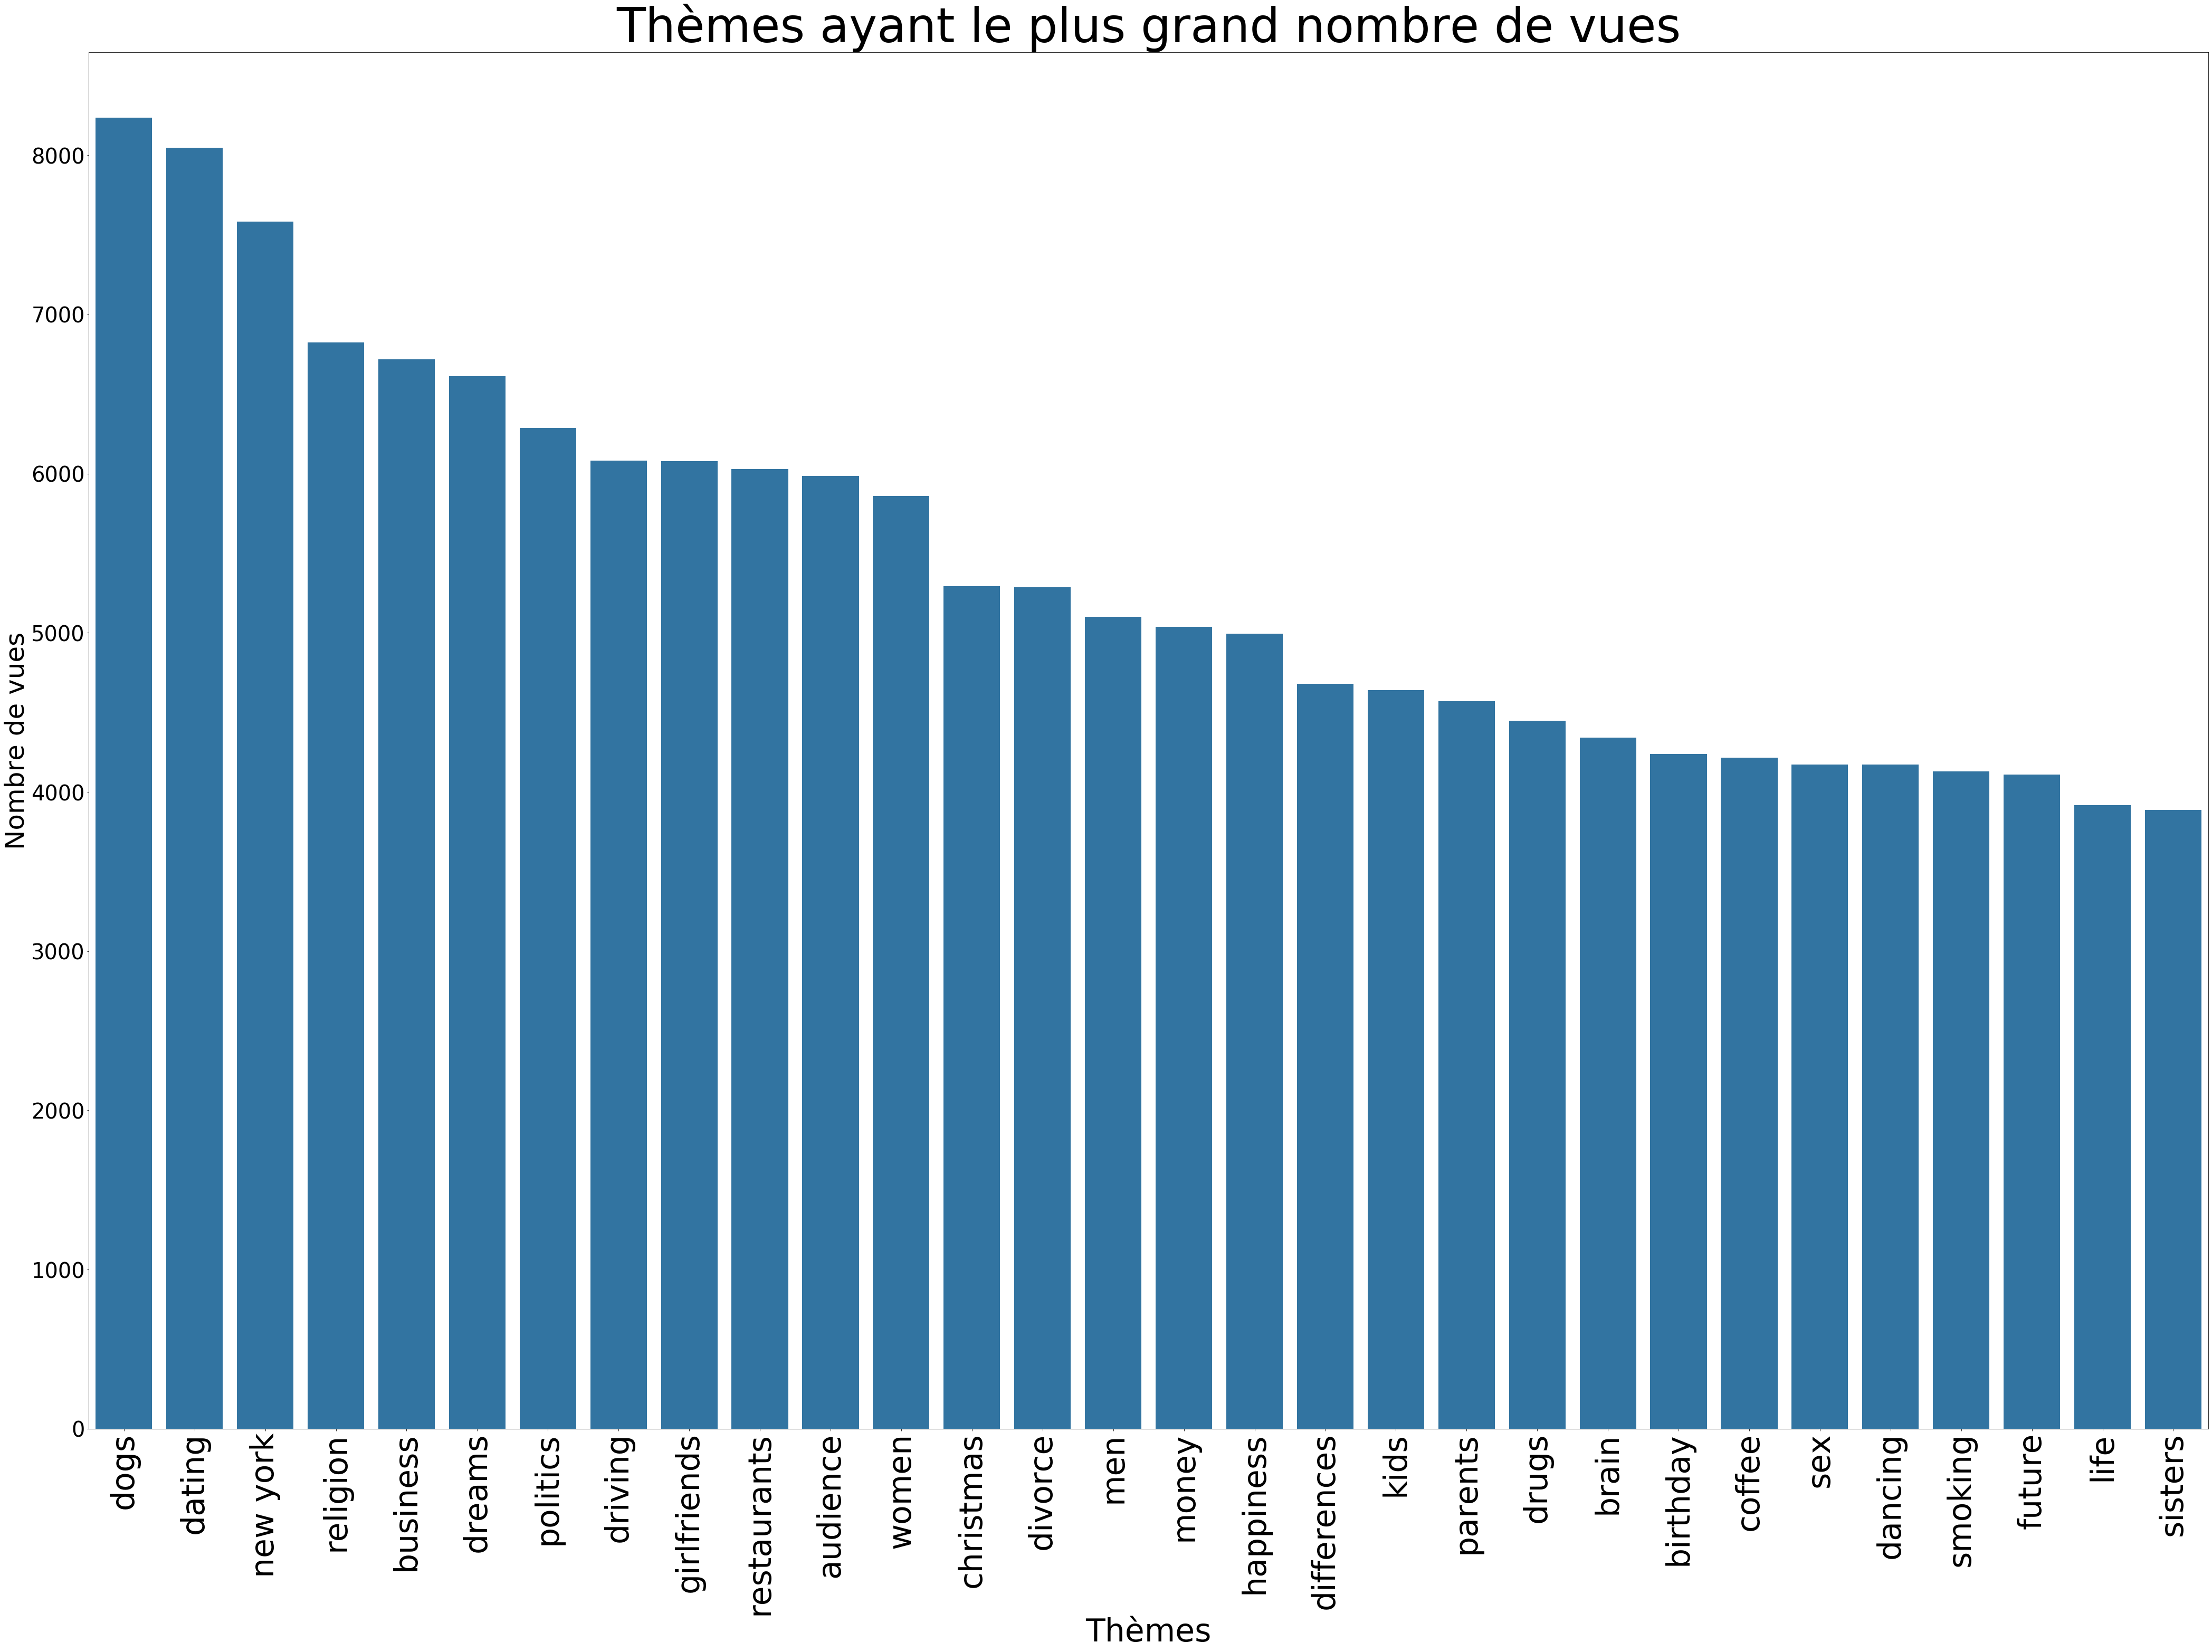

In [15]:
Top_30 = quote_df_theme.sort_values(by='nbre_vues',ascending=False)\
                       .reset_index()\
                       .head(30)

plt.figure(figsize=(72,48))

sns.barplot(x='theme',y='nbre_vues',data=Top_30, color = 'C0')
plt.title("Thèmes ayant le plus grand nombre de vues", fontsize=90)
plt.xticks(rotation=90, fontsize=60)
plt.yticks(fontsize=40)

plt.xlabel('Thèmes', fontsize=60)
plt.ylabel('Nombre de vues', fontsize=50)

plt.savefig('01.Top30Themes_par_nbre-vues.png',dpi=300)

#### Rajout des thèmes manquants :

In [16]:
def preprocess_text(text):
    # Tokenise words while ignoring punctuation
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    return keywords

In [17]:
quote_df_sans_theme = quote_df[quote_df['theme'].isnull()].reset_index()
quote_df_sans_theme = quote_df_sans_theme.drop(columns=['index','theme'])

quote_number = len(quote_df_sans_theme)

themes_manquants = []

for i in range(quote_number):

    quote = quote_df_sans_theme[quote_df_sans_theme.index==i]
    
    word_list = preprocess_text(quote.citation[i])
    
    data = Counter(word_list)
    
    theme_principal = data.most_common(1)
    
    themes_manquants.append(theme_principal)
    
    
dict_theme ={'theme':themes_manquants}
themes_manquants_df = pd.DataFrame(dict_theme)
quote_df_sans_theme = pd.merge(quote_df_sans_theme,themes_manquants_df, left_index=True, right_index=True)


for i in range(quote_number):
    if quote_df_sans_theme.theme[i] != [] :
        quote_df_sans_theme.theme[i]=quote_df_sans_theme.theme[i][0][0]
    else :
        quote_df_sans_theme.theme[i]=None
    
quote_df_sans_theme.head(3)

citation          auteur  \
0  I was the best man to a wedding one time, that...  Jerry Seinfeld   
1  To me, a lawyer is basically the person that k...  Jerry Seinfeld   
2  I'll tell you what I like about Chinese people...  Jerry Seinfeld   

   nbre_vues  genre ethnie religion date_naissance vivant  \
0        480  Homme  blanc    athee     29-04-1954    Oui   
1        323  Homme  blanc    athee     29-04-1954    Oui   
2        304  Homme  blanc    athee     29-04-1954    Oui   

  orientation_sexuelle    theme  
0         heterosexuel      wed  
1         heterosexuel   lawyer  
2         heterosexuel  chinese

#### Classement des nouveaux thèmes par nombre de citations 

In [18]:
NouveauxThemes = quote_df_sans_theme.groupby('theme')['citation'].count()\
                                                                 .reset_index()\
                                                                 .sort_values(by='citation', ascending=False)
                                                                 
NouveauxThemes                                                                 

theme  citation
3013      redneck       246
2204         love       178
2056          kid        91
4016         wife        89
1584          god        79
...           ...       ...
1744  hillbillies         1
1745   hindenberg         1
1748         hips         1
1749      hipster         1
2050      kennedy         1

[4100 rows x 2 columns]

In [19]:
print('Il y a',len(NouveauxThemes),'nouveaux thèmes.')
print(" ")
print(len(NouveauxThemes[NouveauxThemes.citation<6]),'thèmes regroupent seulement moins de 6 citations.')

Il y a 4100 nouveaux thèmes.
 
3645 thèmes regroupent seulement moins de 6 citations.


In [20]:
NouveauxThemesNbreVues = quote_df_sans_theme.groupby('theme')['nbre_vues'].sum()\
                                                                    .reset_index()\
                                                                    .sort_values(by='nbre_vues', ascending=False)
                                                                 
NouveauxThemesNbreVues                                                       

theme  nbre_vues
2204           love       6186
3013        redneck       4936
1499           fuck       4464
2056            kid       3606
4016           wife       3324
...             ...        ...
2525      nostalgic          8
458         bonfire          7
3777   transvestite          6
3124          robin          6
294   autobiography          4

[4100 rows x 2 columns]

Parmi les nouveaux thèmes, certains totalisent un nombre de vues important.

Quelle est la moyenne du nombre de vues par thèmes ?

Combien de vues totalisent les nouveaux thèmes regroupant moins de 6 citations ? 

In [21]:
Mean_vues_par_themes = quote_df.explode('theme')\
                               .groupby('theme').sum()\
                               .reset_index()

Moy = Mean_vues_par_themes.nbre_vues.mean()

print("La moyenne du nombre de vues par thèmes est de",int(Moy),".")

La moyenne du nombre de vues par thèmes est de 2461 .


In [22]:
Diff_NouveauxThemes_NbresVues = pd.merge(NouveauxThemes,NouveauxThemesNbreVues)

Diff_NouveauxThemes_NbresVues = Diff_NouveauxThemes_NbresVues.sort_values(by='nbre_vues',ascending = False)

In [23]:
Diff_NouveauxThemes_NbresVues[Diff_NouveauxThemes_NbresVues.citation<6]

theme  citation  nbre_vues
3457           jill         1       1184
992            iron         3        718
712         anymore         4        653
481           shark         5        645
1967      vagiclean         1        643
...             ...       ...        ...
3762          fussy         1          8
3312        bonfire         1          7
1757   transvestite         1          6
2153          robin         1          6
3026  autobiography         1          4

[3645 rows x 3 columns]

Le nombre de vues pour les nouveaux thèmes regroupant mojns de 6 citations se situe entre 4 et 1184. Ces valeurs restent bien inférieures à la moyenne et sont donc négligeables.

#### Renommage des nouveaux thèmes regroupant moins de 6 citations :

In [24]:
print('En supprimant les thèmes regroupant moins de 5 citations, il reste',
      len(NouveauxThemes)-len(NouveauxThemes[NouveauxThemes.citation<5]), 'nouveaux thèmes, soit un total de',
     len(quote_df_theme.theme.unique())+len(NouveauxThemes)-len(NouveauxThemes[NouveauxThemes.citation<=5]),'thèmes.')

Total_citation_sans_thèmes = NouveauxThemes[NouveauxThemes.citation<5]
Total_citation_sans_thèmes = Total_citation_sans_thèmes.citation.sum()
print(" ")
print(Total_citation_sans_thèmes, "citations n'ont pas de thèmes, soit",round((Total_citation_sans_thèmes/len(quote_df))*100,2),'% du jeu de données.')


En supprimant les thèmes regroupant moins de 5 citations, il reste 570 nouveaux thèmes, soit un total de 656 thèmes.
 
5304 citations n'ont pas de thèmes, soit 28.28 % du jeu de données.


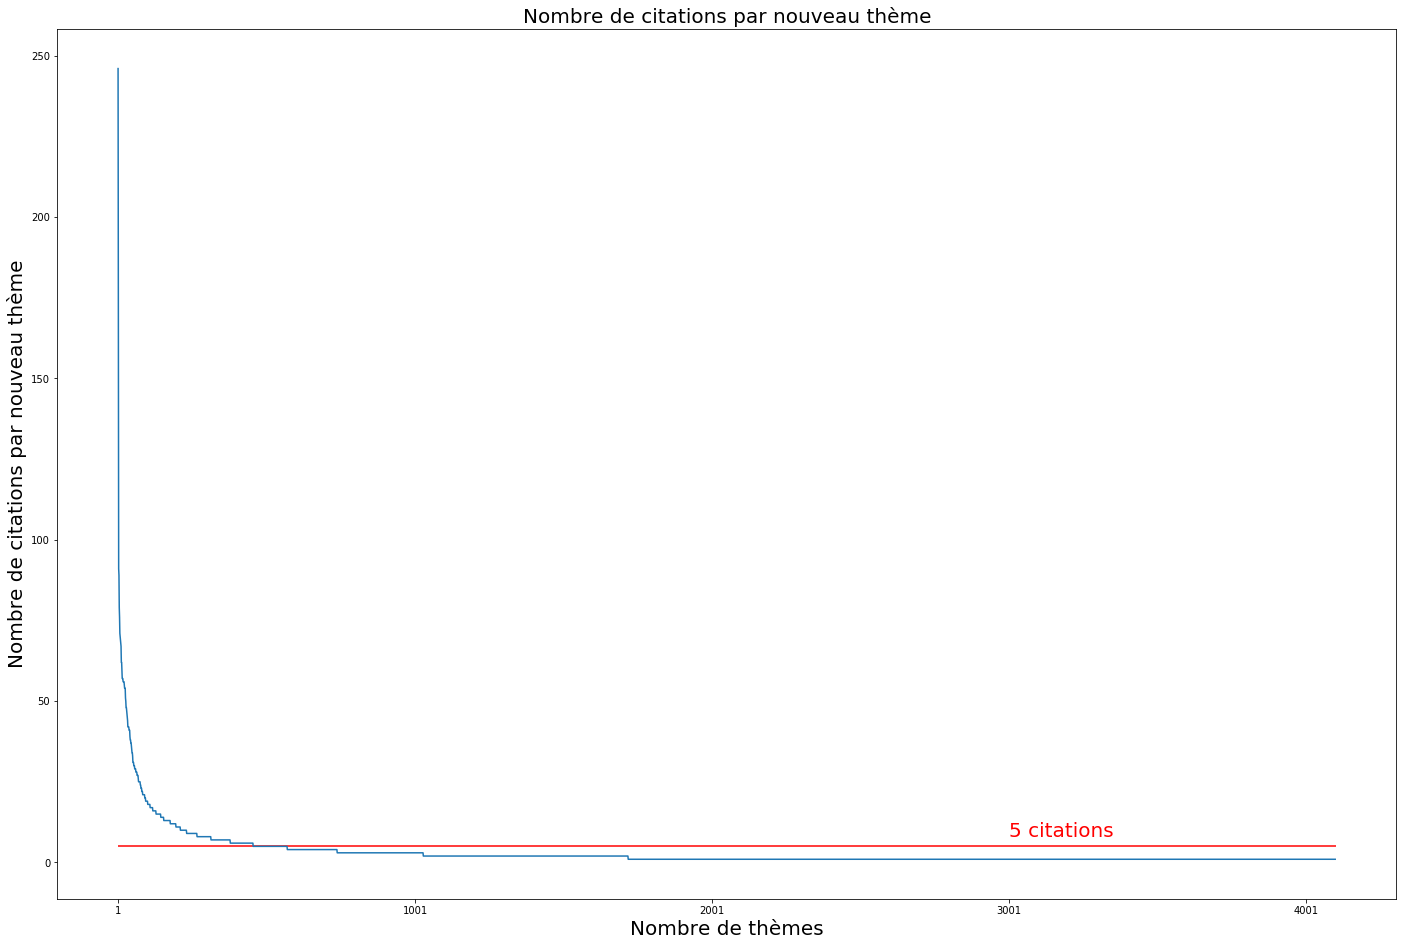

In [25]:
Graph_NouveauxThemes = NouveauxThemes.reset_index()\
                                     .drop(columns=['theme','index'])

fig, ax = plt.subplots(figsize=(24,16))
ax.plot(Graph_NouveauxThemes.index, Graph_NouveauxThemes.citation)
plt.hlines(5, 0, len(Graph_NouveauxThemes), colors='r', linestyles='solid')
plt.xticks(np.arange(1, len(Graph_NouveauxThemes), 1000))
plt.xlabel('Nombre de thèmes', fontsize=20)
plt.ylabel('Nombre de citations par nouveau thème', fontsize=20)
plt.title('Nombre de citations par nouveau thème', fontsize=20)
plt.text(3000,8,"5 citations", color="red", fontsize=20)

plt.savefig("02.nombre_de_citations_par_nouveau_theme.jpg", dpi=300) 

plt.show()

Nous allons attribuer le thème 'Autres' aux citations faisant maximum 5 vues.

In [26]:
Theme_Autres = NouveauxThemes[NouveauxThemes.citation<=5]

quote_df = quote_df.dropna()

quote_df = pd.concat([quote_df, quote_df_sans_theme], ignore_index=True)

quote_df = quote_df.replace({'theme':list(set(list(Theme_Autres.theme.unique()))-set(list(quote_df_theme.theme.unique())))},{'theme':'Autres'}) 
#quote_df = quote_df.replace({'theme':list(Theme_Autres.theme.unique())},{'theme':'Autres'}) 
quote_df.head(3)

citation          auteur  \
0  Well, birthdays are merely symbolic of how ano...  Jerry Seinfeld   
1  "Wait up!" That's what kids say. They don't sa...  Jerry Seinfeld   
2  Women have two orgasms, the real ones and the ...  Jerry Seinfeld   

   nbre_vues                          theme  genre ethnie religion  \
0       1682                     [birthday]  Homme  blanc    athee   
1        427  [kids, life, parents, future]  Homme  blanc    athee   
2        346             [women, accidents]  Homme  blanc    athee   

  date_naissance vivant orientation_sexuelle  
0     29-04-1954    Oui         heterosexuel  
1     29-04-1954    Oui         heterosexuel  
2     29-04-1954    Oui         heterosexuel

In [27]:
list(Theme_Autres.theme.unique())

['story',
 'cannot',
 'consider',
 'reincarnation',
 'candy',
 'music',
 'cookie',
 'tap',
 'build',
 'oprah',
 '100',
 'larry',
 'follow',
 'l',
 'tree',
 'pro',
 'fool',
 'honor',
 'stories',
 '11',
 'steve',
 'bus',
 'deserve',
 'knock',
 '1',
 'relationships',
 'shark',
 'howard',
 'straight',
 'cow',
 'experiment',
 'lay',
 'thirty',
 'accord',
 'explain',
 '7',
 'succeed',
 'owe',
 'race',
 'hi',
 'invisible',
 'surprise',
 'text',
 'raise',
 'absolutely',
 'normal',
 'internet',
 'wow',
 'shy',
 'admire',
 'struggle',
 'tom',
 'careful',
 'hours',
 'carry',
 'definition',
 'definitely',
 'finish',
 'catch',
 'fair',
 'jimmy',
 '30',
 'finally',
 'nerd',
 'pussy',
 'credit',
 'strip',
 'paris',
 'tip',
 'advantage',
 'hat',
 'whose',
 'sense',
 'arrest',
 'magic',
 'em',
 'machine',
 'email',
 'universe',
 'monkey',
 'position',
 'blame',
 'blood',
 'boat',
 'uncle',
 'snow',
 'bomb',
 'pot',
 'santa',
 'pop',
 'draw',
 'english',
 'drop',
 'aware',
 'middle',
 'ball',
 'screw',


In [28]:
print("Les",len(quote_df_sans_theme),"citations sans thèmes sont maintenant classées selon"
      ,len(quote_df_sans_theme.theme.unique()), "thèmes.")
print(" ")
print("Il reste",len(quote_df_sans_theme[quote_df_sans_theme.theme.isnull()]), "citations sans thèmes.")
print(" ")
if len(quote_df_sans_theme[quote_df_sans_theme.theme.isnull()]) != 0 :
    print("Nous allons attribuer un des thèmes existants à chacune de ces citations.")

Les 13426 citations sans thèmes sont maintenant classées selon 4101 thèmes.
 
Il reste 49 citations sans thèmes.
 
Nous allons attribuer un des thèmes existants à chacune de ces citations.


In [29]:
quote_df[quote_df.theme.isnull()]

citation           auteur  \
5593                I do what I can do when I can do it.       Chris Rock   
5990    No one knows what’s next, but everybody does it.    George Carlin   
6082                           Always do whatever's next    George Carlin   
6137                          Always do whatever's next.    George Carlin   
6232   Not only do I not know what's going on, I woul...    George Carlin   
6266         The higher up I went, the less happy I was.   Dave Chappelle   
6944   Don't let's someone walk all over you unless y...        Dane Cook   
7158                  So, do you live around here often?    Steven Wright   
7280   You can't have everything. Where would you put...    Steven Wright   
7334   He asked me if I knew what time it was. I said...    Steven Wright   
7399                         Sometimes I... No, I don't.    Steven Wright   
7508   Well, you can’t have everything. Where would y...    Steven Wright   
7603                           I just want to be myself.       Jim Carrey   
7732    You don't have anything; you don't own anything.   Jeff Foxworthy   
7998                      There's no down time any more.   Jeff Foxworthy   
8783                       Always... no wait... never...     Steve Martin   
8833   It's not what you know, it's what you think yo...     Steve Martin   
8860                     Or is it that I think too much?     Steve Martin   
9014   Nobody can tell me what I can or can't do, exc...        Bob Saget   
9022         When you have a good time there is no time.        Bob Saget   
9028   I can't go back now. I've done it. I've gone a...        Bob Saget   
10111                            Life is for the living.      Woody Allen   
10644  Everything's amazing right now, and nobody's h...      Louis C. K.   
10950  I just don't want to play the same guy again o...       Ray Romano   
10981  Everything that goes up must come down. But th...     George Burns   
11435  Just ’cause you can’t control yours, don’t thr...     George Lopez   
11766                    It doesn't have to be that way.       Bill Cosby   
11814  I wasn't the guy everyone liked. I was the guy...         Jay Mohr   
11916                            Be kind to one another.  Ellen DeGeneres   
12139  If you have your life to live over again, don'...   Henny Youngman   
12198  The more I think of you, the less I think of you.   Henny Youngman   
12277  I wasn't feeling it, really. But I just had to...     Chris Tucker   
12574  Some kind of way, we have to say enough is eno...     Dick Gregory   
12689  The more I get to know people, the less I know...     Dov Davidoff   
12758  I'd like you much better if you didn't like yo...     Dov Davidoff   
12775  Everybody wants to be more wanted, until they ...     Dov Davidoff   
12955  Everybody has to sell out at some point to mak...    Dennis Miller   
13286                The more you want the less you get.    Richard Lewis   
13299               I people-please everyone but myself.    Richard Lewis   
13490          I always knew I shouldn't have said that.      Jon Stewart   
13799            I wouldn't do this if I didn't like it.      David Spade   
14220                      What you see is what you get.      Flip Wilson   
14645         This is not the most right I've ever been.      Paul Reiser   
14913                I don't live to eat, I eat to live.  Martin Lawrence   
15200                   I can't live by your rules, man!   Craig Ferguson   
15528    You don't have to believe everything you think.   Chris Hardwick   
15595  If I had my life to live over... I wouldn't ha...         Bob Hope   
15714  Because here’s what guys don’t do if they can’...    Greg Behrendt   
17947                I said, “Who did you think it was?”       Jimmy Carr   

       nbre_vues theme  genre           ethnie religion date_naissance vivant  \
5593          15  None  Homme   afro-americain    athee     07-02-1965    Oui   
5990          47  None  Homme      

Nous remarquons que deux citations sont encore très similaires :

"You can't have everything. Where would you put it?"

et :

'Well, you can’t have everything. Where would you put it?'

Également :

"Always do whatever's next"

et

"Always do whatever's next."


In [30]:
quote_df.loc[quote_df['citation'] == "You can't have everything. Where would you put it?", 'theme'] += quote_df.loc[quote_df['citation'] == 'Well, you can’t have everything. Where would you put it?'].nbre_vues.values[0]
quote_df.loc[quote_df['citation'] == "Always do whatever's next.", 'theme'] += quote_df.loc[quote_df['citation'] == "Always do whatever's next"].nbre_vues.values[0]

quote_df =quote_df[quote_df.citation != 'Well, you can’t have everything. Where would you put it?']
quote_df =quote_df[quote_df.citation != "Always do whatever's next"]


In [31]:
quote_df.loc[quote_df['citation'] == "I wasn't feeling it, really. But I just had to do what I had to do. It turned out the better for me.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == 'I do what I can do when I can do it.', 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "You don't have to believe everything you think.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "Just cause you got the monkey off your back doesn't mean the circus has left town.", 'theme'] = 'politics'
quote_df.loc[quote_df['citation'] == 'The higher up I went, the less happy I was.', 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == 'The more you want the less you get.', 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "It doesn't have to be that way.", 'theme'] = 'respect'
quote_df.loc[quote_df['citation'] == "You can't have everything. Where would you put it?", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "Sometimes I... No, I don't.", 'theme'] = 'desire'
quote_df.loc[quote_df['citation'] == 'I just want to be myself.', 'theme'] = 'desire'
quote_df.loc[quote_df['citation'] == "There's no down time any more.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "It's not what you know, it's what you think you know.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == 'Or is it that I think too much?', 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == 'When you have a good time there is no time.', 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "If I had my life to live over... I wouldn't have time.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == 'Life is for the living.', 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "Everything's amazing right now, and nobody's happy.", 'theme'] = 'happiness'
quote_df.loc[quote_df['citation'] == "I just don't want to play the same guy again over and over.", 'theme'] = 'desire'
quote_df.loc[quote_df['citation'] == "This is not the most right I've ever been.", 'theme'] = 'decisions'
quote_df.loc[quote_df['citation'] == 'Be kind to one another.', 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == 'The more I think of you, the less I think of you.', 'theme'] = 'desire'
quote_df.loc[quote_df['citation'] == 'Some kind of way, we have to say enough is enough.', 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == 'The more I get to know people, the less I know about people.', 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == 'Everybody wants to be more wanted, until they are...', 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "I'd like you much better if you didn't like yourself so much.", 'theme'] = 'love'
quote_df.loc[quote_df['citation'] == 'Everybody has to sell out at some point to make a living.', 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == 'What you see is what you get.', 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "You can't expect to hit the jackpot if you don't put a few nickels in the machine.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "Just cause you got the monkey off your back doesn't mean the circus has left town.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "I can't live by your rules, man!", 'theme'] = 'laws'
quote_df.loc[quote_df['citation'] == 'No one knows what’s next, but everybody does it.', 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == 'Just ’cause you can’t control yours, don’t throw us all out!', 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "Not only do I not know what's going on, I wouldn't know what to do about it if I did.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "Nobody can tell me what I can or can't do, except they can.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "I can't go back now. I've done it. I've gone and done it.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "If you have your life to live over again, don't do it.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "I wouldn't do this if I didn't like it.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "I don't live to eat, I eat to live.", 'theme'] = 'food'
quote_df.loc[quote_df['citation'] == 'I said, “Who did you think it was?”', 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "Always do whatever's next.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == "Everything that goes up must come down. But there comes a time when not everything that's down can come up.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == 'I people-please everyone but myself.', 'theme'] = 'honesty'
quote_df.loc[quote_df['citation'] == "Don't let's someone walk all over you unless you're into that kind of thing.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == 'So, do you live around here often?', 'theme'] = 'homeless'
quote_df.loc[quote_df['citation'] == 'He asked me if I knew what time it was. I said, "Yes, but not right now."', 'theme'] = 'stupidity'
quote_df.loc[quote_df['citation'] == "You don't have anything; you don't own anything.", 'theme'] = 'experience'
quote_df.loc[quote_df['citation'] == 'Always... no wait... never...', 'theme'] = 'stupidity'
quote_df.loc[quote_df['citation'] == 'Because here’s what guys don’t do if they can’t live without you: they don’t break up with you.', 'theme'] = 'love'
quote_df.loc[quote_df['citation'] == "I wasn't the guy everyone liked. I was the guy that wouldn't shut up.", 'theme'] = 'honesty'
quote_df.loc[quote_df['citation'] == "I always knew I shouldn't have said that.", 'theme'] = 'stupidity'

In [32]:
print("Il y a",len(quote_df[quote_df.theme.isnull()]), "citations sans thèmes.")

if len(quote_df[quote_df.theme.isnull()]) == 0:
    print("Le jeu de données est exploitable.")
else:
    print("Il faut encore attribuer un thème à ces citations.")

Il y a 0 citations sans thèmes.
Le jeu de données est exploitable.


#### Conversion des éléments de la colonne 'date' au format 'datetime'

In [34]:
quote_df['date_naissance'] = pd.to_datetime(quote_df['date_naissance'], infer_datetime_format=True)

quote_df.dtypes


citation                        object
auteur                          object
nbre_vues                        int64
theme                           object
genre                           object
ethnie                          object
religion                        object
date_naissance          datetime64[ns]
vivant                          object
orientation_sexuelle            object
dtype: object

#### Jeu de données définitif

In [35]:
quote_df

citation           auteur  \
0      Well, birthdays are merely symbolic of how ano...   Jerry Seinfeld   
1      "Wait up!" That's what kids say. They don't sa...   Jerry Seinfeld   
2      Women have two orgasms, the real ones and the ...   Jerry Seinfeld   
3      Dogs have no money. Isn't that amazing? They'r...   Jerry Seinfeld   
4      My parents didn't want to move to Florida, but...   Jerry Seinfeld   
...                                                  ...              ...   
18753  You can tell when you’ve gained too much weigh...          Sommore   
18754  This country promised 40 acres and a mule to e...          Sommore   
18755  They got this program called Intervention. Whi...     Tracy Morgan   
18756  I had one DWI, which was a bogus charge, becau...        Ron White   
18757  The N-Word. And everyone says, “Don’t say it a...  Whoopi Goldberg   

       nbre_vues                          theme  genre          ethnie  \
0           1682                     [birthday]  Homme           blanc   
1            427  [kids, life, parents, future]  Homme           blanc   
2            346             [women, accidents]  Homme           blanc   
3            242                         [dogs]  Homme           blanc   
4            223       [parents, laws, florida]  Homme           blanc   
...          ...                            ...    ...             ...   
18753         23                         Autres  Femme  afro-americain   
18754         20                         Autres  Femme  afro-americain   
18755         21                         Autres  Homme  afro-americain   
18756         20                         Autres  Homme           blanc   
18757         20                           word  Femme  afro-americain   

       religion date_naissance vivant orientation_sexuelle  
0         athee     1954-04-29    Oui         heterosexuel  
1         athee     1954-04-29    Oui         heterosexuel  
2         athee     1954-04-29    Oui         heterosexuel  
3         athee     1954-04-29    Oui         heterosexuel  
4         athee     1954-04-29    Oui         heterosexuel  
...         ...            ...    ...                  ...  
18753     athee     1966-05-15    Oui         heterosexuel  
18754     athee     1966-05-15    Oui         heterosexuel  
18755  chretien     1968-11-10    Oui         heterosexuel  
18756     athee     1956-12-18    Oui         heterosexuel  
18757     athee     1955-11-13    Oui         heterosexuel  

[18756 rows x 10 columns]

### <span style="color: #030aa4">Nombre d'humoristes</span>

In [36]:
NbreAuteurParGenre = Auteurs_df.groupby('genre').count()\
                               .drop(columns=['ethnie','religion','date_naissance','vivant','orientation_sexuelle'])

NbreAuteurParGenre['Pourcentage']=(NbreAuteurParGenre['auteur']/NbreAuteurParGenre['auteur'].sum())*100

NbreAuteurParGenre

auteur  Pourcentage
genre                     
Femme      41    14.089347
Homme     250    85.910653

In [37]:
print("Il y a",len(quote_df.groupby('auteur').count()),"artistes.")
print("Il y a seulement",NbreAuteurParGenre.auteur[0],"femmes, soit",round(NbreAuteurParGenre.Pourcentage[0],2),"%.")
print("Le stand-up américain semble être un monde d'hommes.")

Il y a 291 artistes.
Il y a seulement 41 femmes, soit 14.09 %.
Le stand-up américain semble être un monde d'hommes.


### <span style="color: #030aa4">Âge des humoristes vivants</span>

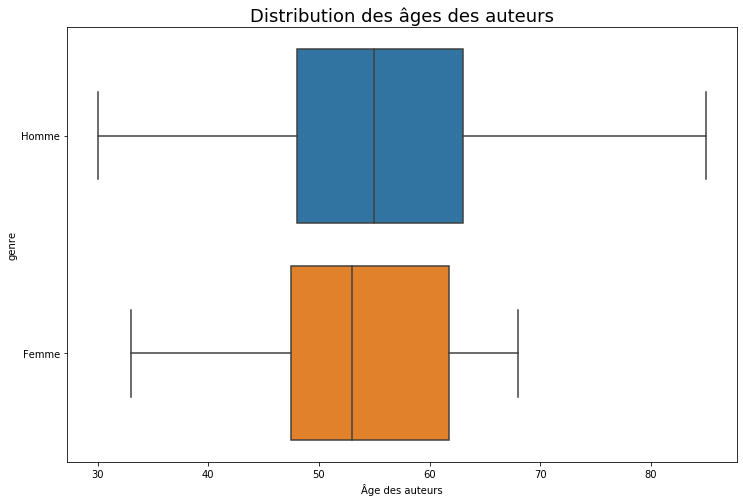

In [38]:
quote_df['annee_naissance']=quote_df['date_naissance'].dt.year

quote_df_age = quote_df.copy()

quote_df_age = quote_df_age[quote_df_age.vivant=='Oui']

quote_df_age['age']= 2020-quote_df['annee_naissance']

quote_df_age = quote_df_age.groupby(['auteur','genre']).mean()\
                           .reset_index()\
                           .drop(columns=['nbre_vues','annee_naissance'])

plt.figure(figsize=(12,8))

sns.boxplot(x=quote_df_age['age'], y=quote_df_age['genre'], data=quote_df_age,showfliers=False, orient='h')

plt.title("Distribution des âges des auteurs", fontsize=18)

ax = plt.axes()
ax = ax.set(xlabel='Âge des auteurs')

plt.savefig("03.Boxplot_age_auteurs.jpg", dpi=300) 

#### Moyenne d'âge :

In [39]:
quote_df_age.groupby('genre').mean()

age
genre           
Femme  53.394737
Homme  55.669951

In [40]:
quote_age_homme = quote_df_age[quote_df_age.genre=='Homme']
quote_age_femme = quote_df_age[quote_df_age.genre=='Femme']

print("La moyenne d'âge des humoristes est de",round(quote_df_age.age.mean(),0),'ans.')
print(" ")
print("La moyenne d'âge des femmes est de",round(quote_age_femme.age.mean(),0),'ans.')
print(" ")
print("La moyenne d'âge des hommes est de",round(quote_age_homme.age.mean(),0),'ans.')
print(" ")
print("La femme la plus jeune a",round(quote_age_femme.age.min(),0),'ans.')
print(" ")
print("La femme la plus âgée a",round(quote_age_femme.age.max(),0),'ans.')
print(" ")
print("L'homme le plus jeune a",round(quote_age_homme.age.min(),0),'ans.')
print(" ")
print("L'homme le plus âgé a",round(quote_age_homme.age.max(),0),'ans.')
print(" ")
print("L'âge modal pour les hommes est de",round(quote_age_homme.age.mode()[0],0),'ans.')
print(" ")
print("L'âge modal pour les femmes est de",round(quote_age_femme.age.mode()[0],0),'ans.')
print(" ")
print("L'âge médian pour les hommes est de",round(quote_age_homme.age.median(),0),'ans.')
print(" ")
print("L'âge médian pour les femmes est de",round(quote_age_femme.age.median(),0),'ans.')

La moyenne d'âge des humoristes est de 55.0 ans.
 
La moyenne d'âge des femmes est de 53.0 ans.
 
La moyenne d'âge des hommes est de 56.0 ans.
 
La femme la plus jeune a 33.0 ans.
 
La femme la plus âgée a 68.0 ans.
 
L'homme le plus jeune a 30.0 ans.
 
L'homme le plus âgé a 93.0 ans.
 
L'âge modal pour les hommes est de 52.0 ans.
 
L'âge modal pour les femmes est de 50.0 ans.
 
L'âge médian pour les hommes est de 55.0 ans.
 
L'âge médian pour les femmes est de 53.0 ans.


In [74]:
AuteursMorts = Auteurs_df[Auteurs_df.vivant=='Non']

AuteursMorts[AuteursMorts.genre=='Femme']

auteur  genre ethnie religion date_naissance vivant  \
150     Joan Rivers  Femme  blanc     juif     08-06-1933    Non   
187    Lucille Ball  Femme  blanc    athee     06-08-1911    Non   
225  Phyllis Diller  Femme  blanc    athee     17-07-1917    Non   

    orientation_sexuelle  
150         heterosexuel  
187         heterosexuel  
225         heterosexuel

In [41]:
quote_age_homme.sort_values(by='age',ascending=False)

auteur  genre   age
170        Mort Sahl  Homme  93.0
28       Bob Newhart  Homme  91.0
180       Pat Cooper  Homme  91.0
238      Woody Allen  Homme  85.0
110     Jackie Mason  Homme  84.0
..               ...    ...   ...
104  Hannibal Buress  Homme  37.0
209      Seann Walsh  Homme  35.0
11   Andrew Lawrence  Homme  32.0
109   Jack Whitehall  Homme  32.0
27        Bo Burnham  Homme  30.0

[203 rows x 3 columns]

In [42]:
quote_age_homme.sort_values(by='age')

auteur  genre   age
27        Bo Burnham  Homme  30.0
109   Jack Whitehall  Homme  32.0
11   Andrew Lawrence  Homme  32.0
209      Seann Walsh  Homme  35.0
104  Hannibal Buress  Homme  37.0
..               ...    ...   ...
110     Jackie Mason  Homme  84.0
238      Woody Allen  Homme  85.0
28       Bob Newhart  Homme  91.0
180       Pat Cooper  Homme  91.0
170        Mort Sahl  Homme  93.0

[203 rows x 3 columns]

In [43]:
quote_age_femme.sort_values(by='age',ascending=False)

auteur  genre   age
200      Roseanne Barr  Femme  68.0
195        Rita Rudner  Femme  67.0
236    Whoopi Goldberg  Femme  65.0
220       Susie Essman  Femme  65.0
207    Sandra Bernhard  Femme  65.0
189         Rene Hicks  Femme  64.0
40        Carol Leifer  Femme  64.0
136        Judy Tenuta  Femme  64.0
34        Brett Butler  Femme  62.0
83     Ellen DeGeneres  Femme  62.0
186   Paula Poundstone  Femme  61.0
138      Kathy Griffin  Femme  60.0
152    Lisa Lampanelli  Femme  59.0
135          Judy Gold  Femme  58.0
210   Sheryl Underwood  Femme  57.0
234        Wanda Sykes  Femme  56.0
112   Janeane Garofalo  Femme  56.0
137   Kathleen Madigan  Femme  55.0
212            Sommore  Femme  54.0
157       Margaret Cho  Femme  52.0
155      Lynne Koplitz  Femme  51.0
147  Laura Kightlinger  Femme  51.0
158      Maria Bamford  Femme  50.0
227           Tina Fey  Femme  50.0
208    Sarah Silverman  Femme  50.0
3          Aisha Tyler  Femme  50.0
223         Tig Notaro  Femme  49.0
8          Amy Poehler  Femme  49.0
32    Bonnie McFarlane  Femme  47.0
117        Jen Kirkman  Femme  46.0
172    Natasha Leggero  Femme  46.0
43     Chelsea Handler  Femme  45.0
143     Kristen Schaal  Femme  42.0
44     Chelsea Peretti  Femme  42.0
9          Amy Schumer  Femme  39.0
235   Whitney Cummings  Femme  38.0
107   Iliza Shlesinger  Femme  37.0
206   Sabrina Matthews  Femme  33.0

In [44]:
quote_age_femme.sort_values(by='age')

auteur  genre   age
206   Sabrina Matthews  Femme  33.0
107   Iliza Shlesinger  Femme  37.0
235   Whitney Cummings  Femme  38.0
9          Amy Schumer  Femme  39.0
44     Chelsea Peretti  Femme  42.0
143     Kristen Schaal  Femme  42.0
43     Chelsea Handler  Femme  45.0
172    Natasha Leggero  Femme  46.0
117        Jen Kirkman  Femme  46.0
32    Bonnie McFarlane  Femme  47.0
8          Amy Poehler  Femme  49.0
223         Tig Notaro  Femme  49.0
158      Maria Bamford  Femme  50.0
3          Aisha Tyler  Femme  50.0
208    Sarah Silverman  Femme  50.0
227           Tina Fey  Femme  50.0
147  Laura Kightlinger  Femme  51.0
155      Lynne Koplitz  Femme  51.0
157       Margaret Cho  Femme  52.0
212            Sommore  Femme  54.0
137   Kathleen Madigan  Femme  55.0
112   Janeane Garofalo  Femme  56.0
234        Wanda Sykes  Femme  56.0
210   Sheryl Underwood  Femme  57.0
135          Judy Gold  Femme  58.0
152    Lisa Lampanelli  Femme  59.0
138      Kathy Griffin  Femme  60.0
186   Paula Poundstone  Femme  61.0
83     Ellen DeGeneres  Femme  62.0
34        Brett Butler  Femme  62.0
189         Rene Hicks  Femme  64.0
136        Judy Tenuta  Femme  64.0
40        Carol Leifer  Femme  64.0
207    Sandra Bernhard  Femme  65.0
220       Susie Essman  Femme  65.0
236    Whoopi Goldberg  Femme  65.0
195        Rita Rudner  Femme  67.0
200      Roseanne Barr  Femme  68.0

### <span style="color: #030aa4">Nombre de vues des citations selon le genre</span>

In [45]:
#data= pd.merge(Genre_df,quote_df)

CitationParGenre = quote_df.loc[:,('genre','nbre_vues')]\
                           .groupby('genre').sum()

CitationParGenre['Pourcentage_nbre_vues']=(CitationParGenre['nbre_vues']/CitationParGenre['nbre_vues'].sum())*100

CitationParGenre

nbre_vues  Pourcentage_nbre_vues
genre                                  
Femme      68236               7.697297
Homme     818257              92.302703

In [46]:
print("Le nombre total de vues s'élève à",CitationParGenre.nbre_vues.sum(),".")
print(" ")
print("Il y a",CitationParGenre.nbre_vues[0], "vues pour les citations dont l'auteur est une femme, soit seulement",round(CitationParGenre.Pourcentage_nbre_vues[0],2),"%.")
print("Il y a",CitationParGenre.nbre_vues[1], "vues pour les citations dont l'auteur est un homme, soit",round(CitationParGenre.Pourcentage_nbre_vues[1],2),"%.")
print(" ")
print("Cela confirme que les hommes sont beaucoup plus représentés que les femmes.")

Le nombre total de vues s'élève à 886493 .
 
Il y a 68236 vues pour les citations dont l'auteur est une femme, soit seulement 7.7 %.
Il y a 818257 vues pour les citations dont l'auteur est un homme, soit 92.3 %.
 
Cela confirme que les hommes sont beaucoup plus représentés que les femmes.


### <span style="color: #030aa4">Nombre de citations par humoriste</span>

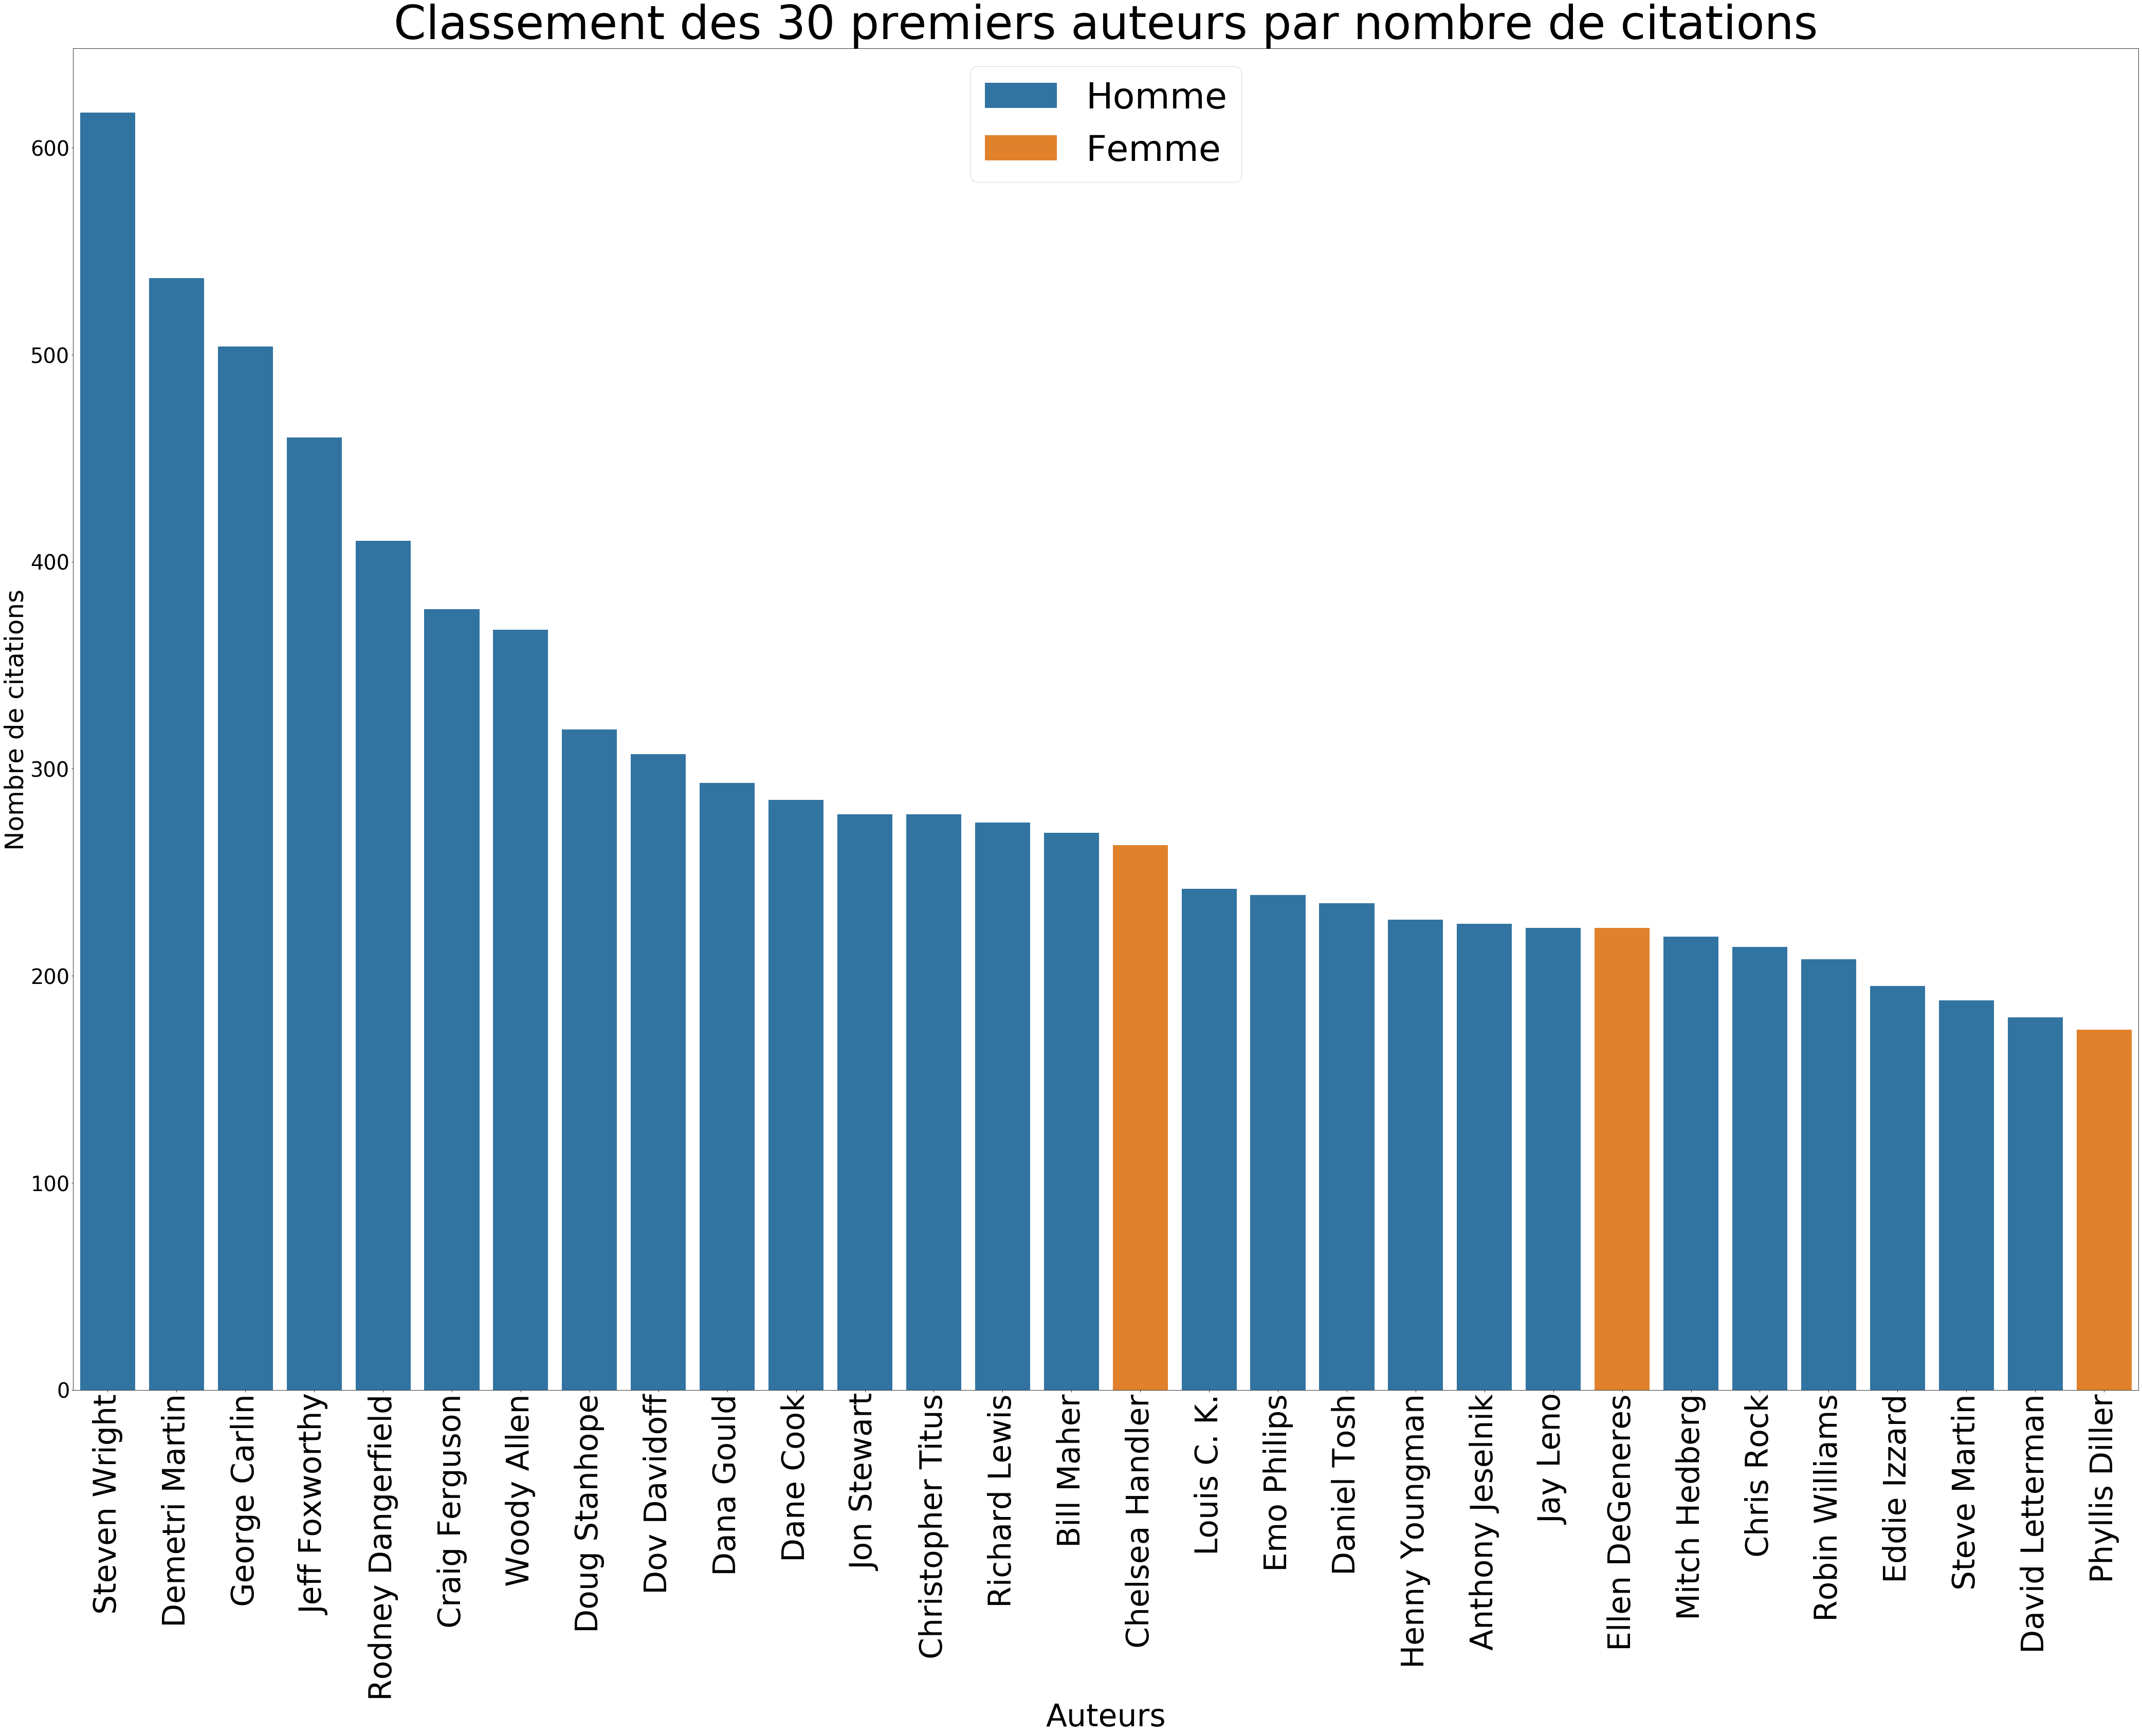

In [50]:
Nbre_citation_auteur = quote_df.loc[ : , ('citation','auteur','genre')]\
                               .groupby(['auteur','genre'])['citation'].count().reset_index()

Nbre_citation_auteur = Nbre_citation_auteur.sort_values(by="citation", ascending=False)
 
Nbre_citation_auteur.reset_index(inplace = True)
Nbre_citation_auteur = Nbre_citation_auteur.drop(columns='index')
Nbre_citation_auteur.index +=1
Top30_Nbre_citation_auteur = Nbre_citation_auteur.head(30)

plt.figure(figsize=(72,48))

sns.barplot(x='auteur',y='citation',data=Top30_Nbre_citation_auteur,hue="genre", dodge=False)
plt.title("Classement des 30 premiers auteurs par nombre de citations", fontsize=90)
plt.xticks(rotation=90, fontsize=60)
plt.yticks(fontsize=40)

plt.xlabel('Auteurs', fontsize=60)
plt.ylabel('Nombre de citations', fontsize=50)
plt.legend(prop={"size":70})

plt.savefig("04.Top30_auteurs_par_nbre_citations.jpg", dpi=300) 

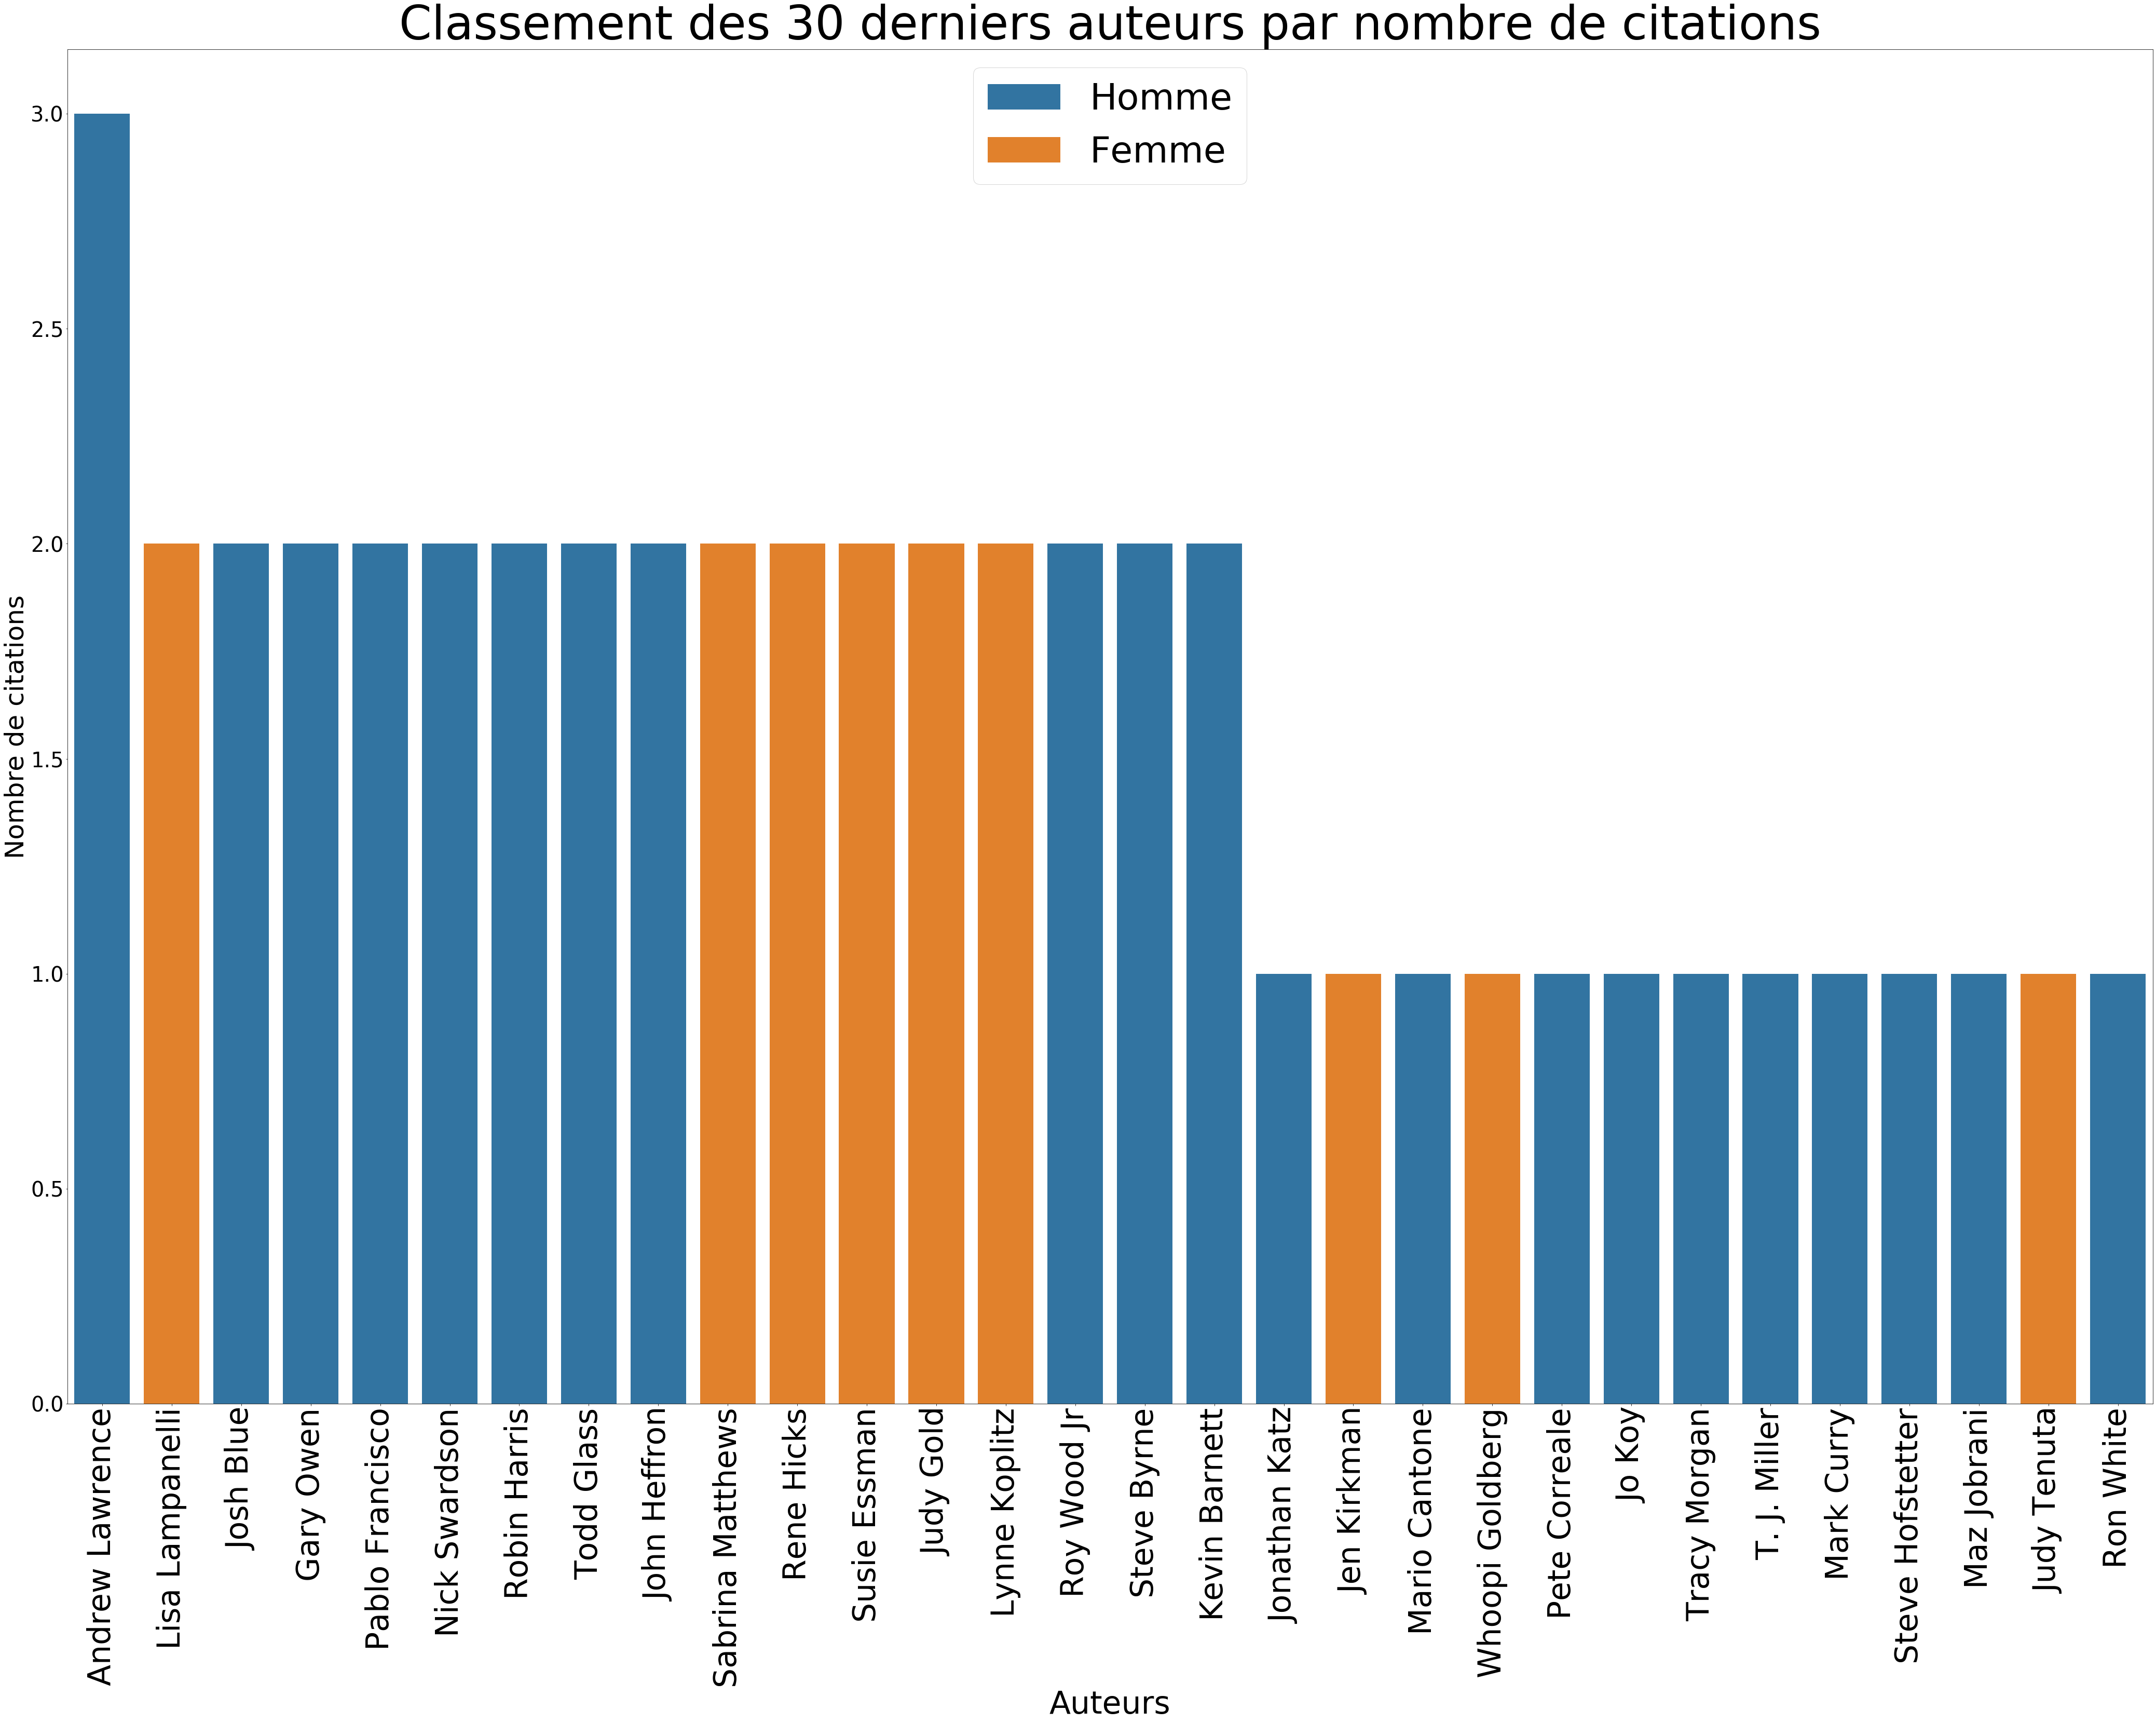

In [51]:
Flop30_Nbre_citation_auteur = Nbre_citation_auteur.tail(30)

plt.figure(figsize=(72,48))

sns.barplot(x='auteur',y='citation',data=Flop30_Nbre_citation_auteur,hue="genre", dodge=False)
plt.title("Classement des 30 derniers auteurs par nombre de citations", fontsize=90)
plt.xticks(rotation=90, fontsize=60)
plt.yticks(fontsize=40)

plt.xlabel('Auteurs', fontsize=60)
plt.ylabel('Nombre de citations', fontsize=50)
plt.legend(prop={"size":70})

plt.savefig("05.Flop30_auteurs_par_nbre_citations.jpg", dpi=300)

In [52]:
Nbre_citation_Femme = Nbre_citation_auteur[Nbre_citation_auteur.genre=='Femme']
Nbre_Femme_Top_30 = Top30_Nbre_citation_auteur[Top30_Nbre_citation_auteur.genre=='Femme']
Nbre_Femme_Flop_30 = Flop30_Nbre_citation_auteur[Flop30_Nbre_citation_auteur.genre=='Femme']


print("Les trois premiers auteurs par nombre de citations sont :")
print(" ")
print("1.",Nbre_citation_auteur.auteur[1],"avec",Nbre_citation_auteur.citation[1],"citations")
print("2.",Nbre_citation_auteur.auteur[2],"avec",Nbre_citation_auteur.citation[2],"citations")
print("3.",Nbre_citation_auteur.auteur[3],"avec",Nbre_citation_auteur.citation[3],"citations")
print(" ")
print("Nous pouvons constater que le Top 30 ne comporte que",len(Nbre_Femme_Top_30),"femmes.")
print(" ")
print("La première femme de ce classement se nomme",Nbre_citation_Femme.auteur[Nbre_citation_Femme.index[0]],".")
print("Elle se place à la",Nbre_citation_Femme.index[0],"ème position avec",Nbre_citation_Femme.citation[Nbre_citation_Femme.index[0]],'citations.')
print(" ")
print("La deuxième femme de ce classement se nomme",Nbre_citation_Femme.auteur[Nbre_citation_Femme.index[1]],".")
print("Elle se place à la",Nbre_citation_Femme.index[1],"ème position avec",Nbre_citation_Femme.citation[Nbre_citation_Femme.index[1]],'citations.')
print(" ") 
print("La troisième femme de ce classement se nomme",Nbre_citation_Femme.auteur[Nbre_citation_Femme.index[2]],".")
print("Elle se place à la",Nbre_citation_Femme.index[2],"ème position avec",Nbre_citation_Femme.citation[Nbre_citation_Femme.index[2]],'citations.')
print(" ")
print("À l'inverse, les 50 dernières places de ce classement sont occupées par",len(Nbre_Femme_Flop_30),"femmes.")
print(" ")
print("Ce classement montre à nouveau que les femmes sont mal représentées dans le milieu de l'humour américain.")

Les trois premiers auteurs par nombre de citations sont :
 
1. Steven Wright avec 617 citations
2. Demetri Martin avec 537 citations
3. George Carlin avec 504 citations
 
Nous pouvons constater que le Top 30 ne comporte que 3 femmes.
 
La première femme de ce classement se nomme Chelsea Handler .
Elle se place à la 16 ème position avec 263 citations.
 
La deuxième femme de ce classement se nomme Ellen DeGeneres .
Elle se place à la 23 ème position avec 223 citations.
 
La troisième femme de ce classement se nomme Phyllis Diller .
Elle se place à la 30 ème position avec 174 citations.
 
À l'inverse, les 50 dernières places de ce classement sont occupées par 9 femmes.
 
Ce classement montre à nouveau que les femmes sont mal représentées dans le milieu de l'humour américain.


### <span style="color: #030aa4">Nombre de citations Homme/Femme</span>

In [87]:
NombreCitationHommeFemme = quote_df.loc[:,('genre','citation')]\
                                   .groupby('genre').count()

NombreCitationHommeFemme["Pourcentage"]=(NombreCitationHommeFemme['citation']/NombreCitationHommeFemme['citation'].sum())*100

print("Le nombre total de citations s'élève à",NombreCitationHommeFemme.citation.sum(),"citations.")
print(" ")
print("Il y a",NombreCitationHommeFemme.citation[0], "citations dont l'auteur est une femme, soit seulement",round(NombreCitationHommeFemme.Pourcentage[0],2),"%.")
print("Il y a",NombreCitationHommeFemme.citation[1], "citations dont l'auteur est un homme, soit",round(NombreCitationHommeFemme.Pourcentage[1],2),"%.")
print(" ")
print("Une fois de plus, les hommes sont beaucoup plus représentés que les femmes.")

Le nombre total de citations s'élève à 18756 citations.
 
Il y a 1787 citations dont l'auteur est une femme, soit seulement 9.53 %.
Il y a 16969 citations dont l'auteur est un homme, soit 90.47 %.
 
Une fois de plus, les hommes sont beaucoup plus représentés que les femmes.


In [89]:
NombreVuesHommesFemmes = quote_df.loc[:,('genre','nbre_vues')]\
                                   .groupby('genre').sum()

NombreVuesHommesFemmes["Pourcentage"]=round((NombreVuesHommesFemmes['nbre_vues']/NombreVuesHommesFemmes['nbre_vues'].sum())*100,2)

NombreVuesHommesFemmes

nbre_vues  Pourcentage
genre                        
Femme      68236          7.7
Homme     818257         92.3

### <span style="color: #030aa4">Nombre de thèmes</span>

In [54]:
quote_df_theme = quote_df.explode('theme')\
                         .loc[ : , ('theme','nbre_vues')]\
                         .groupby('theme').sum().reset_index()\
                         .sort_values(by='nbre_vues',ascending=False)

quote_df_theme=quote_df_theme[quote_df_theme.theme!='Autres']

print("Il y a",len(quote_df_theme), "thèmes.")

Il y a 632 thèmes.


In [55]:
quote_df_theme.head(10)

theme  nbre_vues
354      love       9472
169      dogs       8236
143    dating       8046
616     women       7706
395  new york       7582
612      wife       7211
469  religion       6825
81   business       6735
173    dreams       6612
494       sex       6568

### <span style="color: #030aa4">Quels thèmes plaisent le plus ?</span>

#### <span style="color: #a40334"> Quels sont les thèmes ayant le plus de succès ?</span>

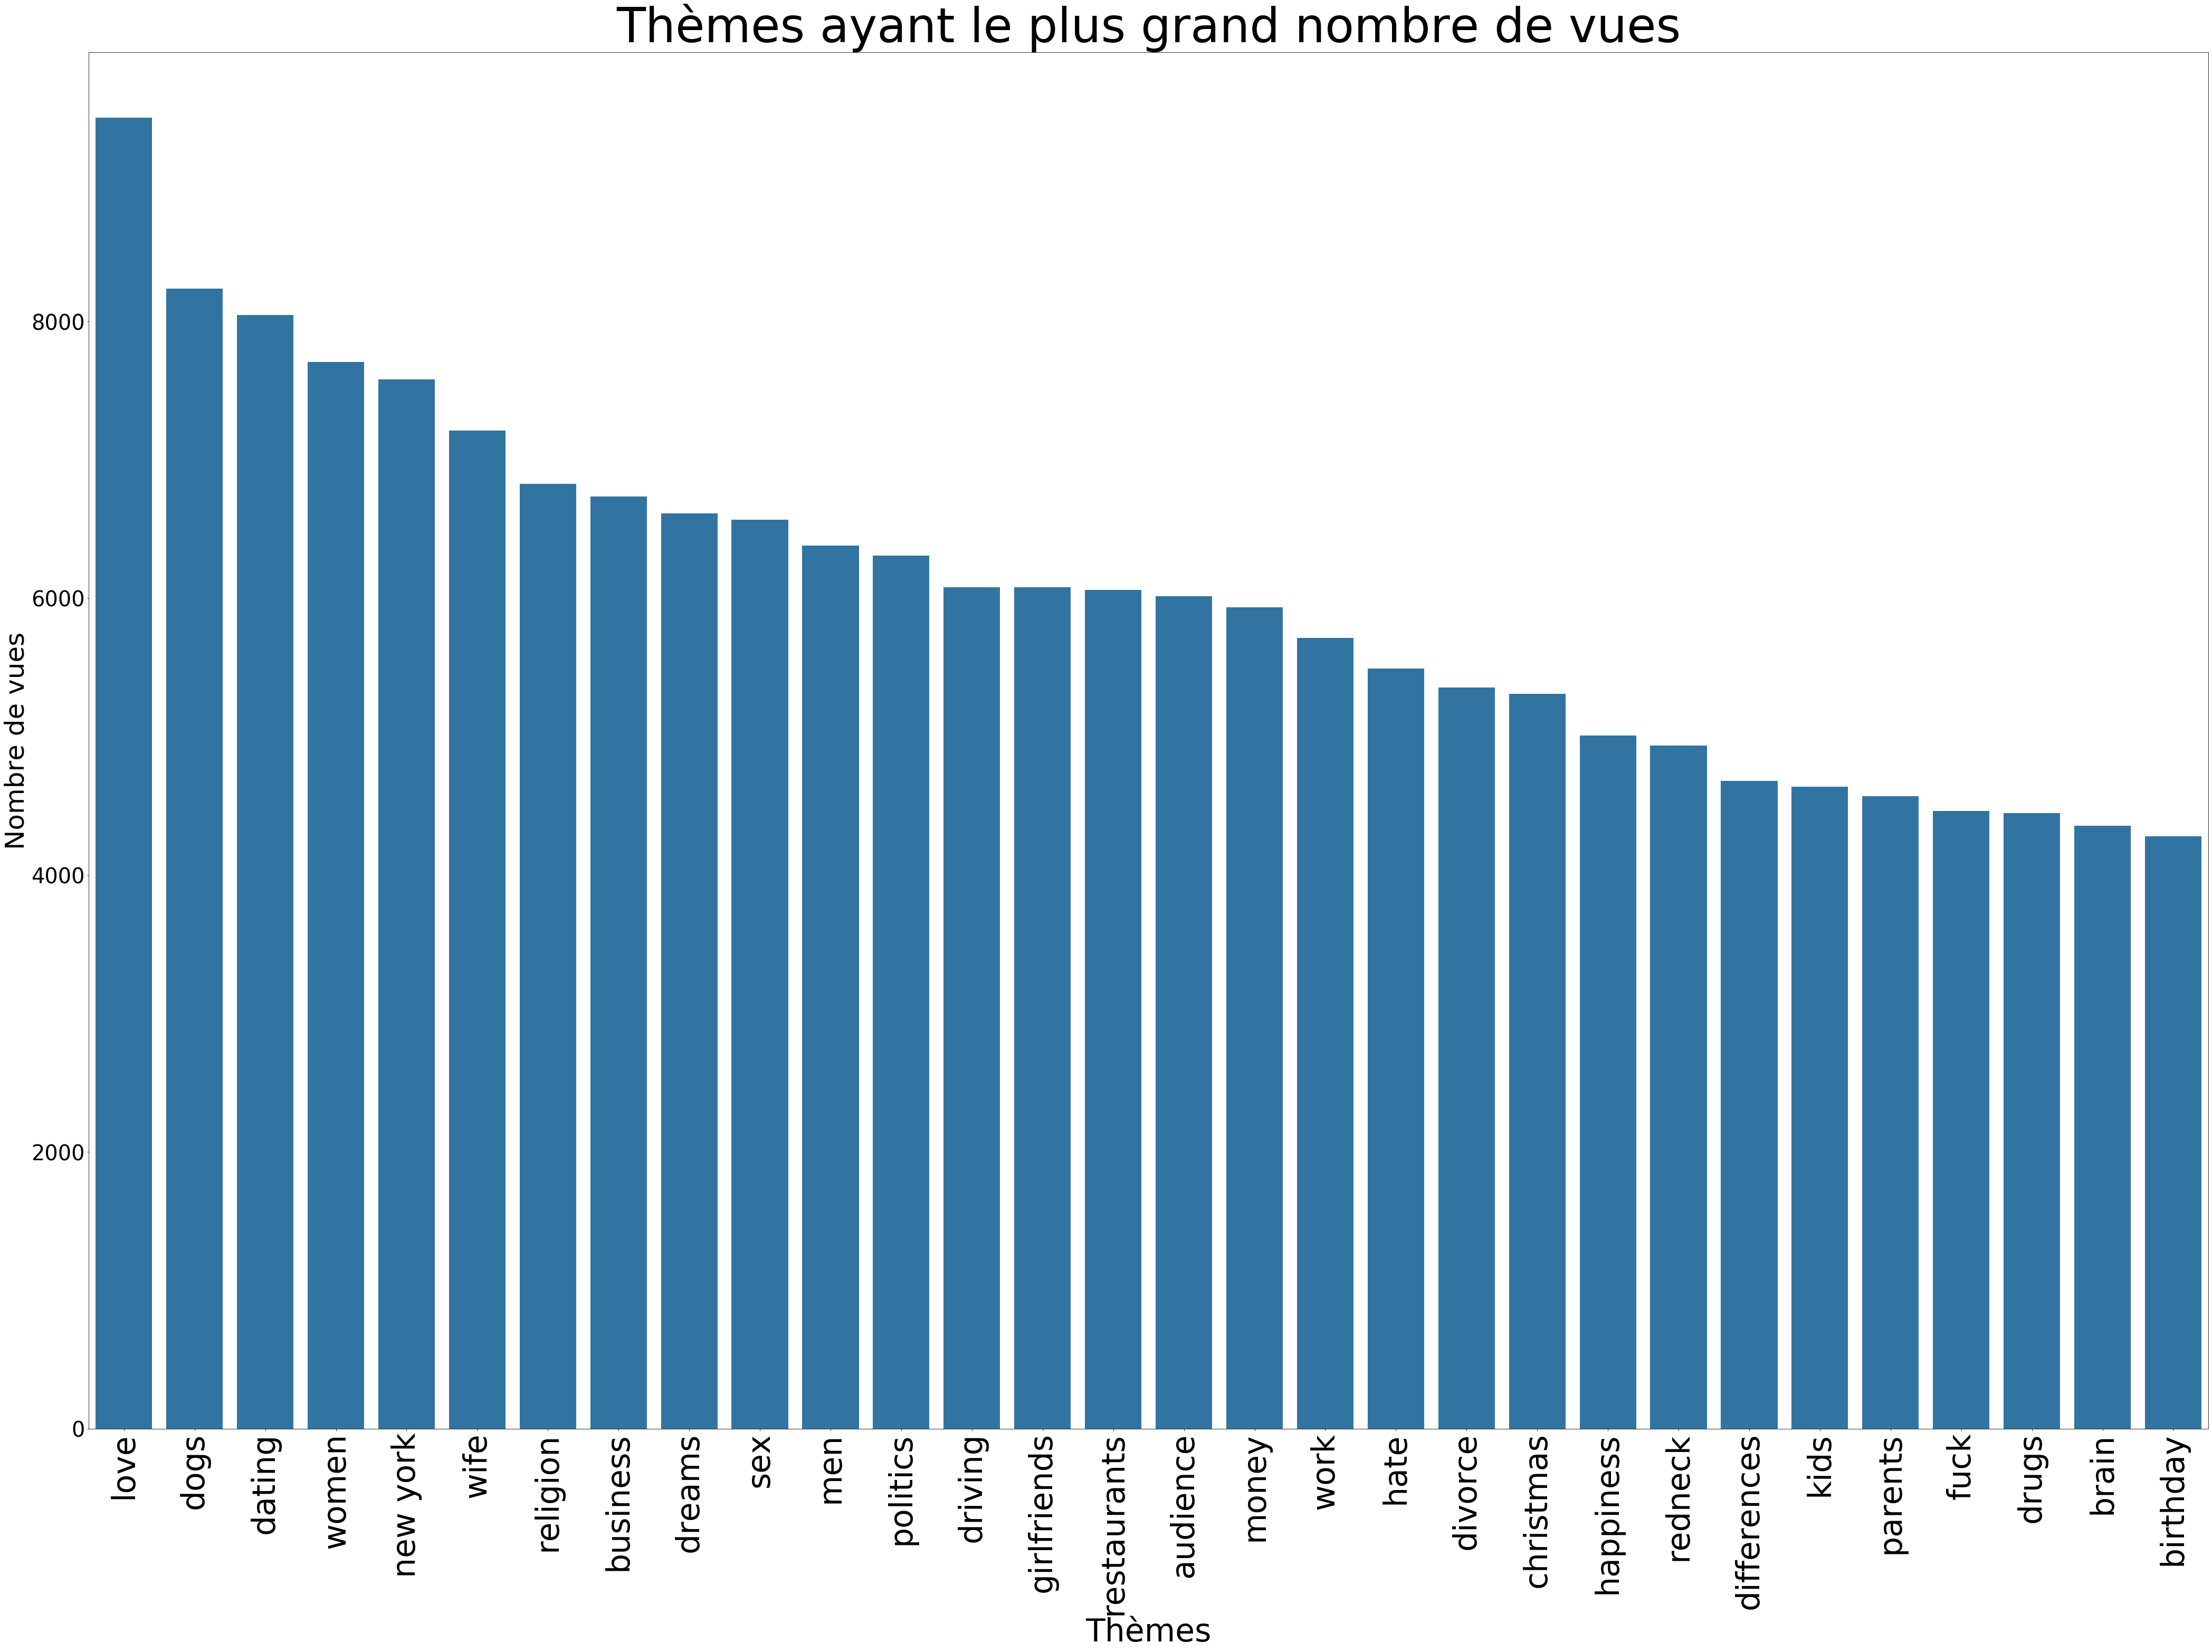

In [56]:
Top_30 = quote_df_theme.head(30)

plt.figure(figsize=(72,48))

sns.barplot(x='theme',y='nbre_vues',data=Top_30, color = 'C0')
plt.title("Thèmes ayant le plus grand nombre de vues", fontsize=90)
plt.xticks(rotation=90, fontsize=60)
plt.yticks(fontsize=40)

plt.xlabel('Thèmes', fontsize=60)
plt.ylabel('Nombre de vues', fontsize=50)

plt.savefig("06.Top30_themes_par_nbre_vues.jpg", dpi=300)

#### <span style="color: #a40334"> Quels thèmes rassemblent 80% des nombres de vues ? </span>

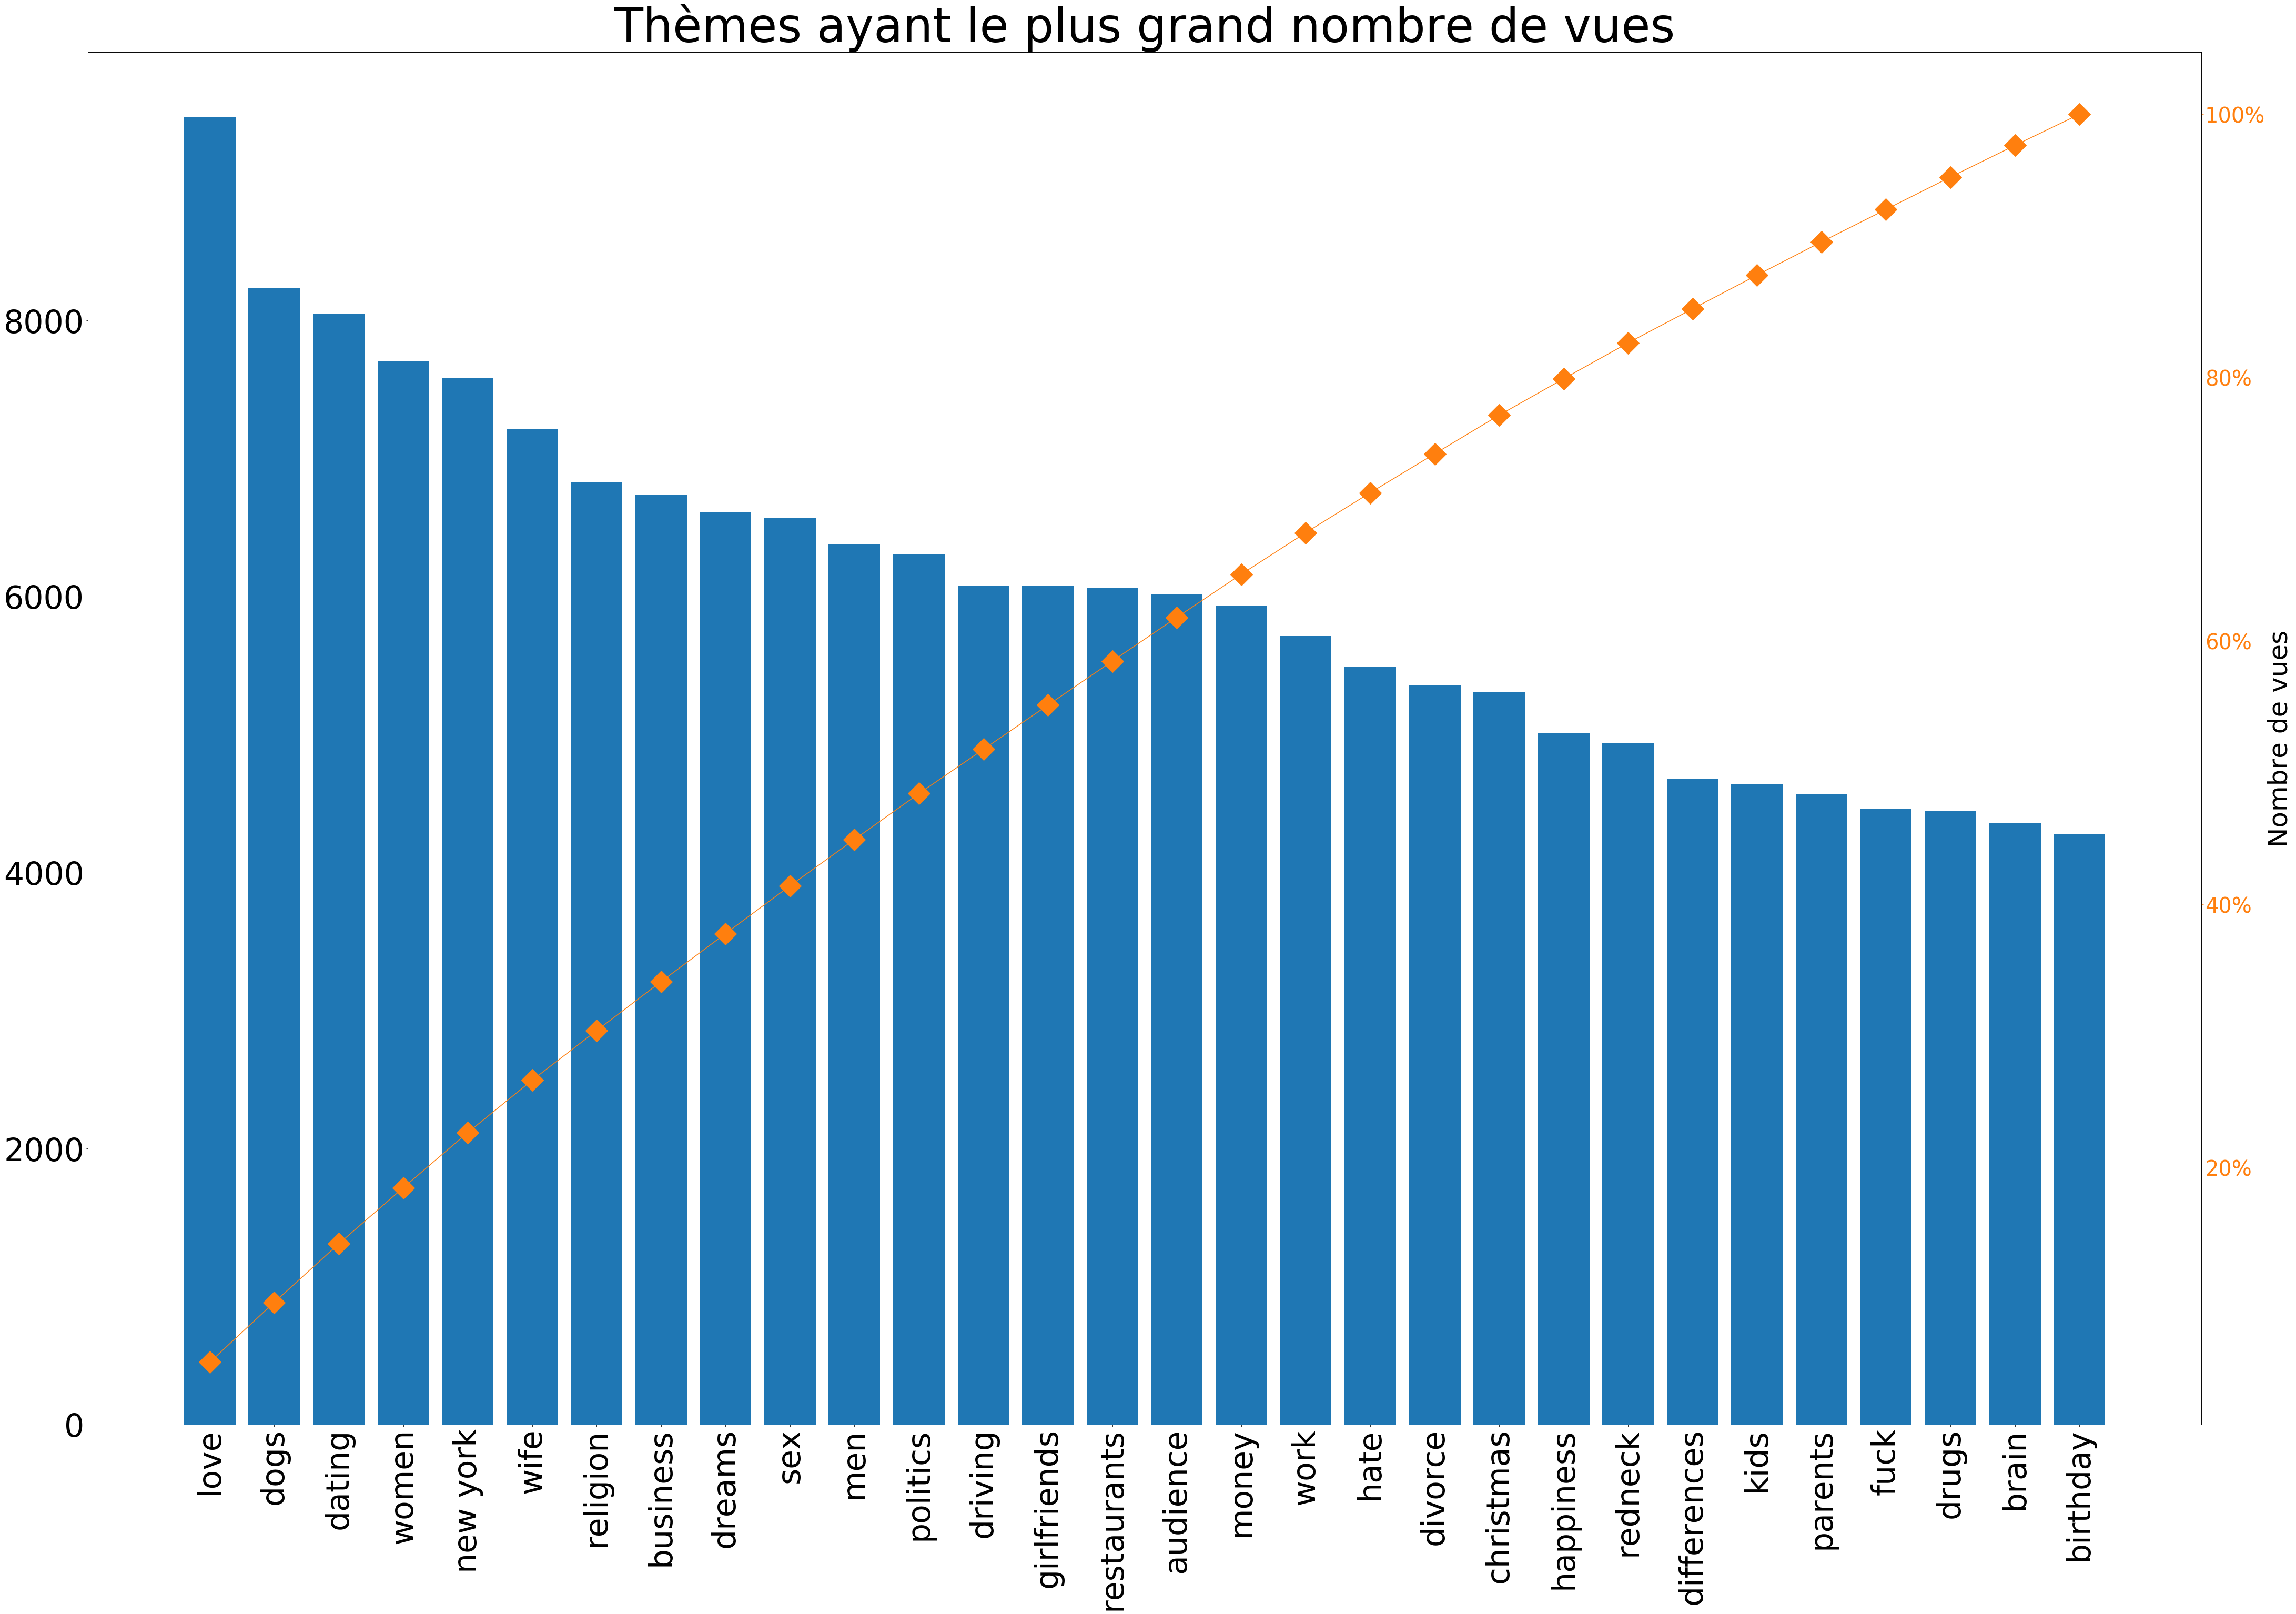

In [57]:
Top_30 = quote_df_theme.head(30)

Top_30.index = list(Top_30.theme)#df = df.sort_values(by='country',ascending=False)
Top_30['cumpercentage'] = Top_30['nbre_vues'].cumsum()/Top_30['nbre_vues'].sum()*100

#plt.figure(figsize=(72,48))

fig, ax = plt.subplots(figsize=(72,48))
plt.title("Thèmes ayant le plus grand nombre de vues", fontsize=90)
ax.bar(Top_30.index, Top_30['nbre_vues'], color="C0")
ax2 = ax.twinx()
ax2.plot(Top_30.index, Top_30['cumpercentage'], color="C1", marker="D", ms=30)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y")
ax2.tick_params(axis="y", colors="C1")

plt.xticks(rotation=90, fontsize=60)
plt.yticks(fontsize=40)

plt.xlabel('Thèmes', fontsize=60)
plt.ylabel('Nombre de vues', fontsize=50)

ax.tick_params(axis='x', which='major', labelsize=60,rotation=90)
ax.tick_params(axis='y', which='major', labelsize=60)
ax.tick_params(axis='both', which='minor', labelsize=60)

plt.savefig("07.Top30_themes_par_nbre_vues_Paretto.jpg", dpi=300)

plt.show()

In [58]:
Paretto = quote_df.explode('theme')\
                  .groupby('theme').sum()\
                  .sort_values(by='nbre_vues',ascending=False)\
                  .drop(columns='annee_naissance')\
                  .reset_index()

Paretto = Paretto[Paretto.theme!='Autres']

print("Nombre de vues totales :",Paretto.nbre_vues.sum())
print(" ")
print("80% Nombre de vues totales :",Paretto.nbre_vues.sum()*0.8)

Paretto

Nombre de vues totales : 777734
 
80% Nombre de vues totales : 622187.2000000001


theme  nbre_vues
1         love       9472
2         dogs       8236
3       dating       8046
4        women       7706
5     new york       7582
..         ...        ...
628  valentine        135
629     answer        133
630    history        127
631     shrink        124
632    weather        121

[632 rows x 2 columns]

#### <span style="color: #a40334"> Ces thèmes sont-ils toujours abordés par les mêmes comédiens ? </span>

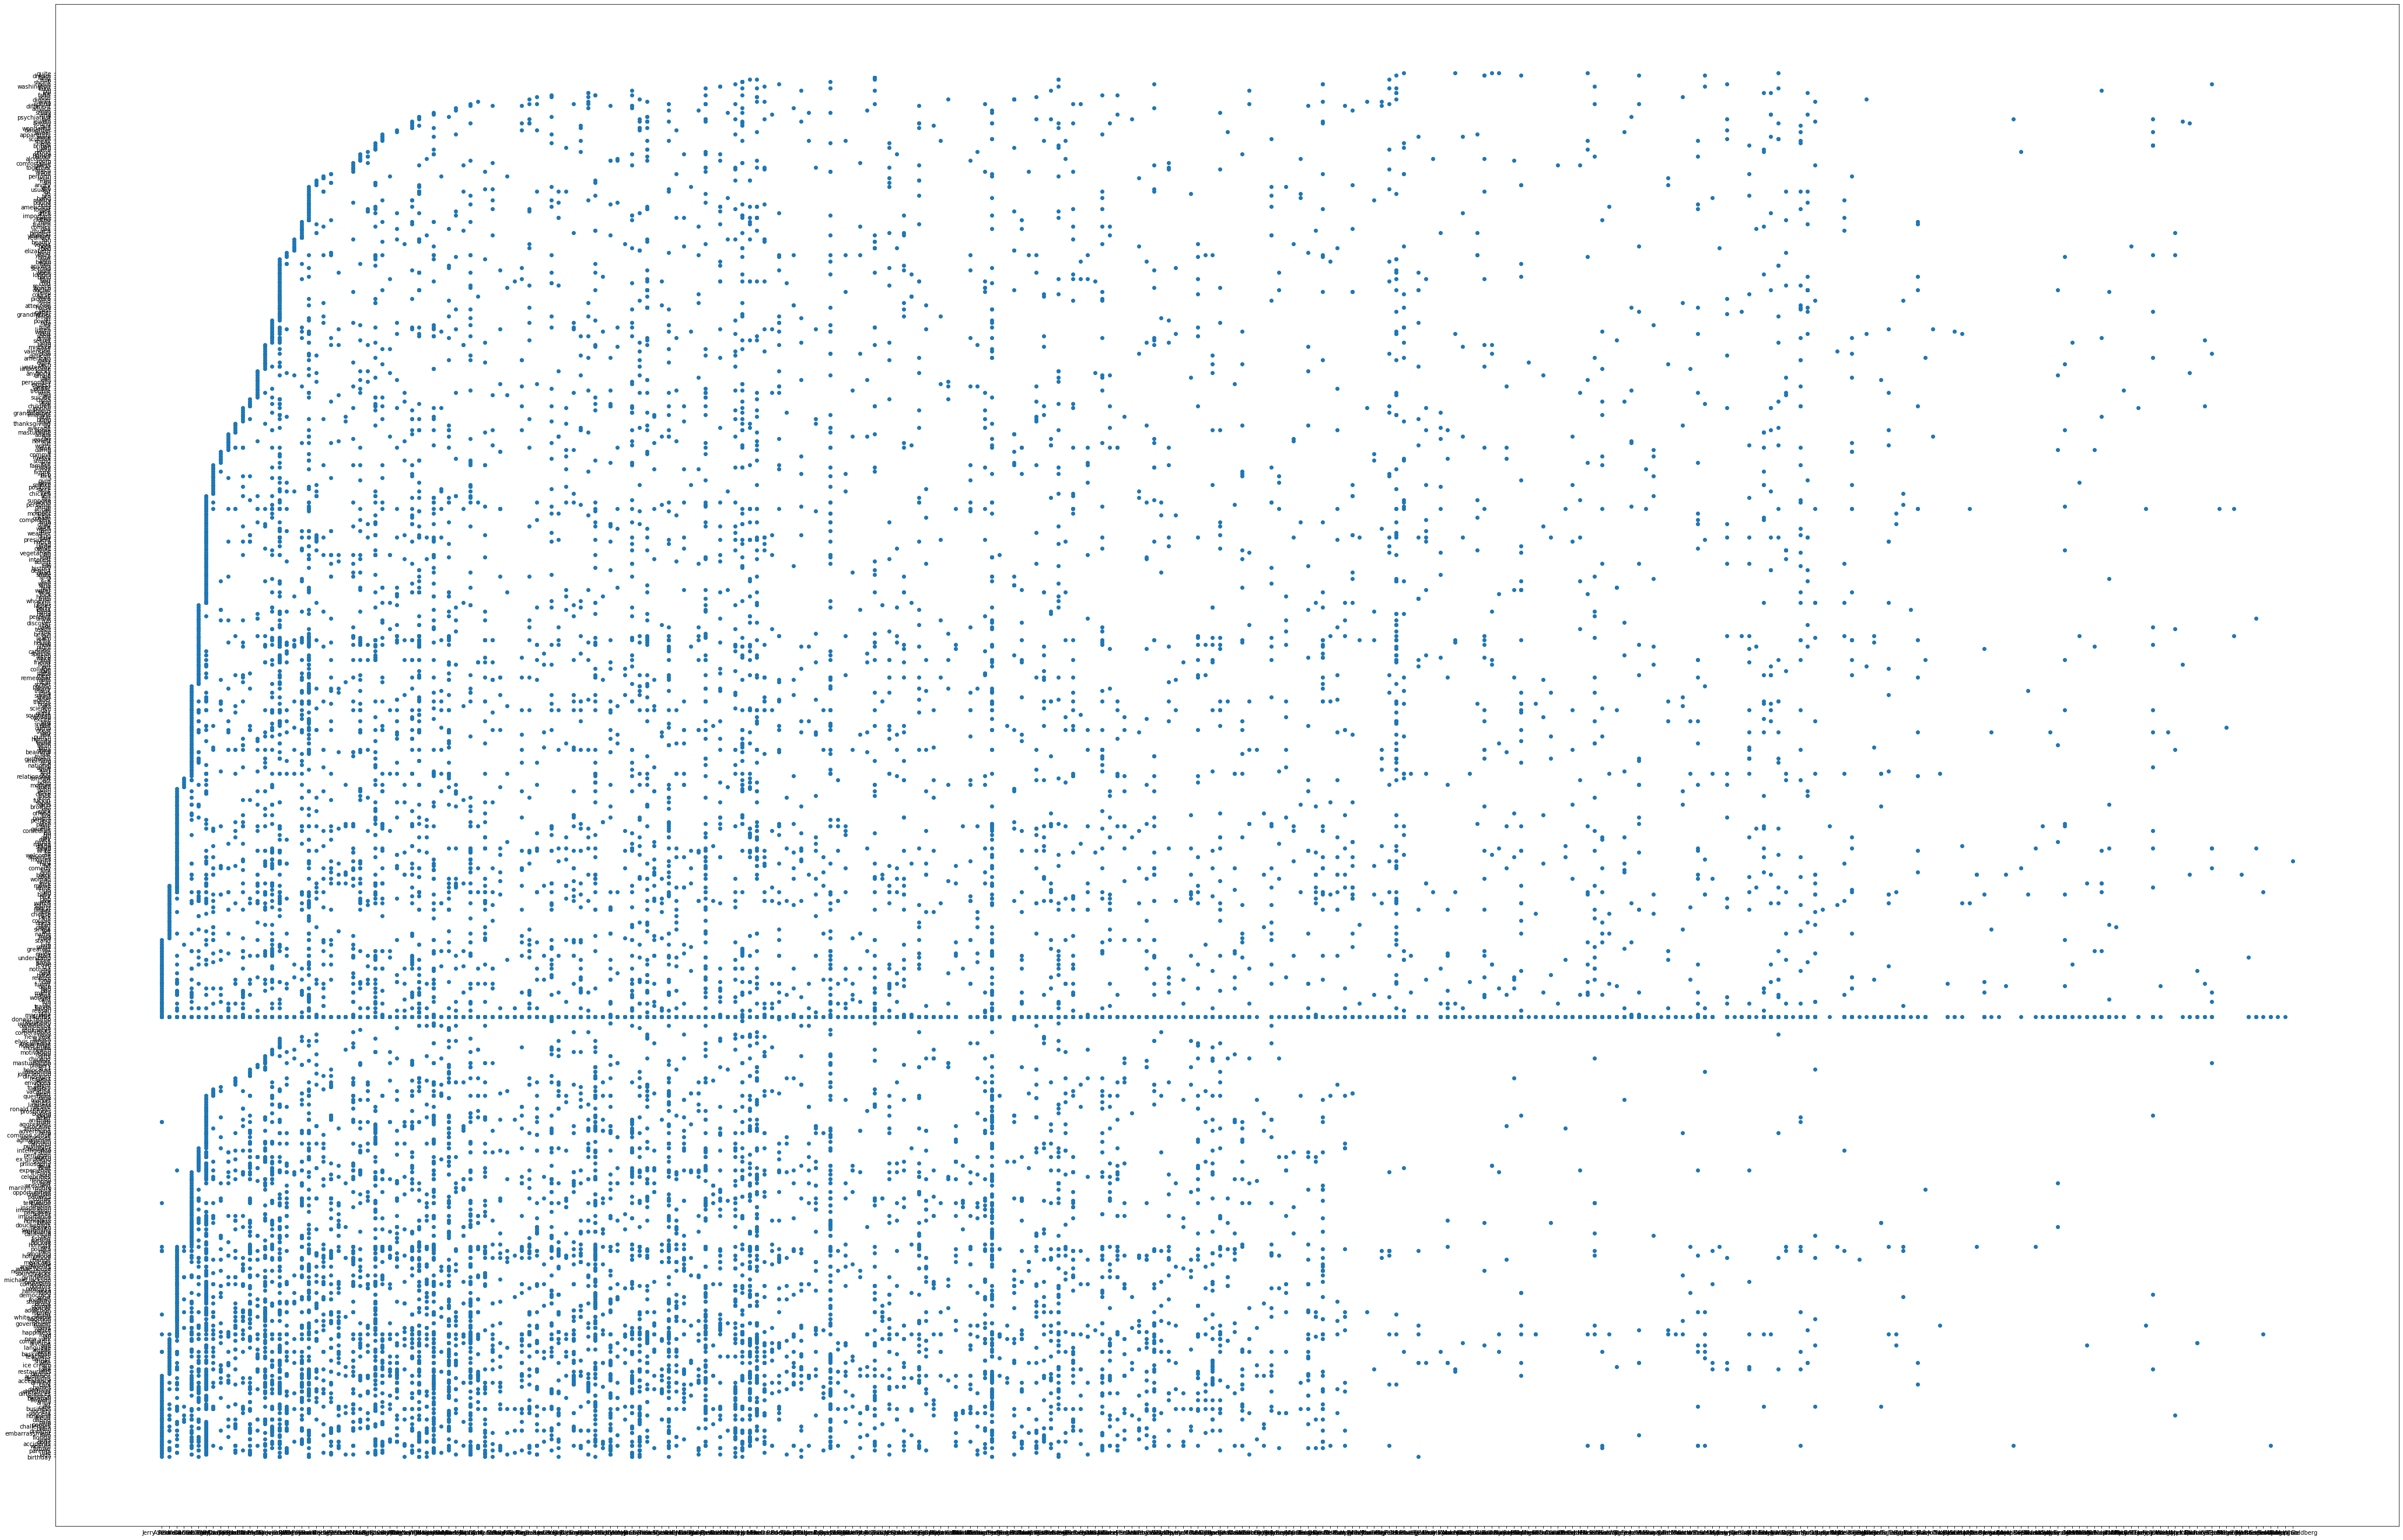

In [59]:
# Nuage de points, en abscisse : nom des comédiens / en ordonnée : nom des thèmes
quote_df_theme_auteur = quote_df.explode('theme')\
                                .dropna()

plt.figure(figsize=(72,48))
#sns.jointplot('auteur','theme',data=quote_df_theme_auteur)
plt.scatter(quote_df_theme_auteur.auteur, quote_df_theme_auteur.theme)

### <span style="color: #030aa4">Quels humoristes ont le plus de succès ?</span>

#### <span style="color: #a40334"> Quel est celui dont la citation a le plus de nombre de vues ?</span>

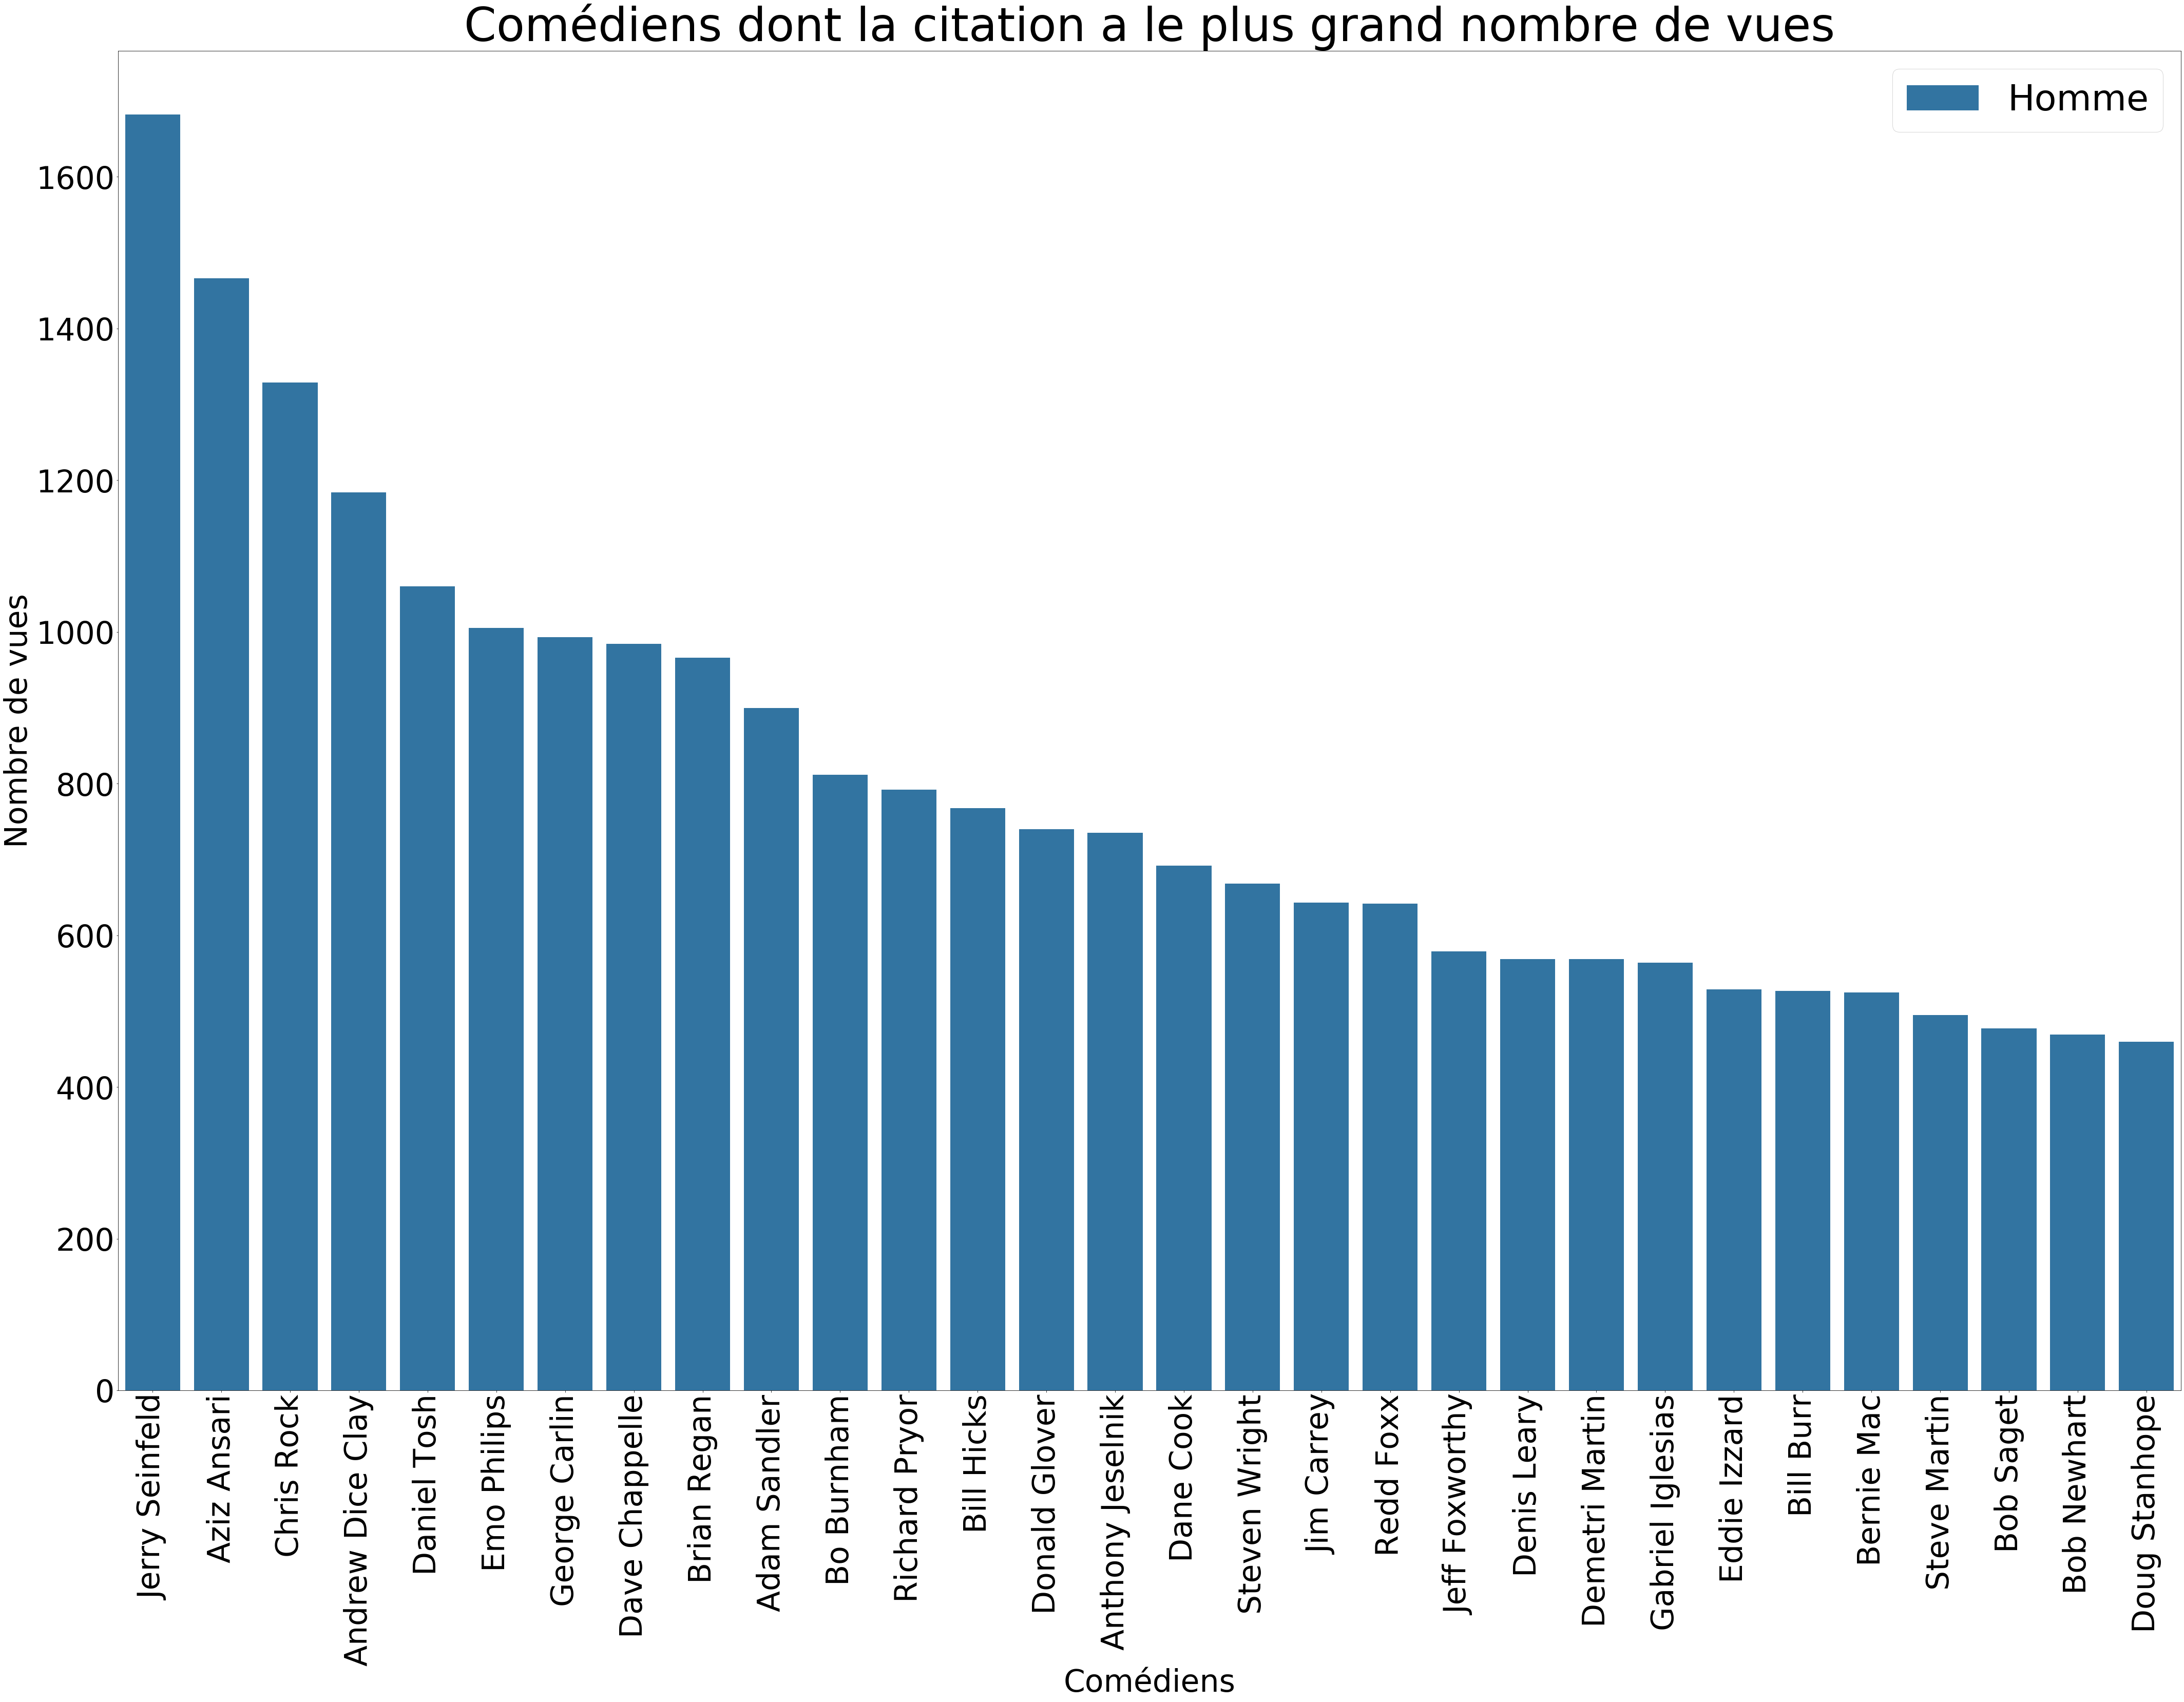

In [60]:
# Histogramme, en abscisse : nom des comédiens / en ordonnée : nombre de vues
quote_df_auteur_max_nbre_vues = quote_df.loc[:,('auteur','nbre_vues','genre')]\
                                        .sort_values(by='nbre_vues',ascending=False)\
                                        .drop_duplicates(subset='auteur')\
                                        .head(30)

plt.figure(figsize=(72,48))

sns.barplot(x='auteur',y='nbre_vues',data=quote_df_auteur_max_nbre_vues,hue="genre", dodge=False)
plt.title("Comédiens dont la citation a le plus grand nombre de vues", fontsize=90)
plt.xticks(rotation=90, fontsize=60)
plt.yticks(fontsize=60)

plt.xlabel('Comédiens', fontsize=60)
plt.ylabel('Nombre de vues', fontsize=60)
plt.legend(prop={"size":70})

plt.savefig("07.Top30_comediens_par_citation_avec_nbre_vues.jpg", dpi=300) 

In [110]:
quote_df.citation[0]

"Well, birthdays are merely symbolic of how another year has gone by and how little we've grown. No matter how desperate we are that someday a better self will emerge, with each flicker of the candles on the cake, we know it's not to be, that for the rest of our sad, wretched pathetic lives, this is who we areto the bitter end. Inevitably, irrevocably; happy birthday? No such thing."

#### <span style="color: #a40334"> Quels sont ceux dont la citation a le moins de nombre de vues ?</span>

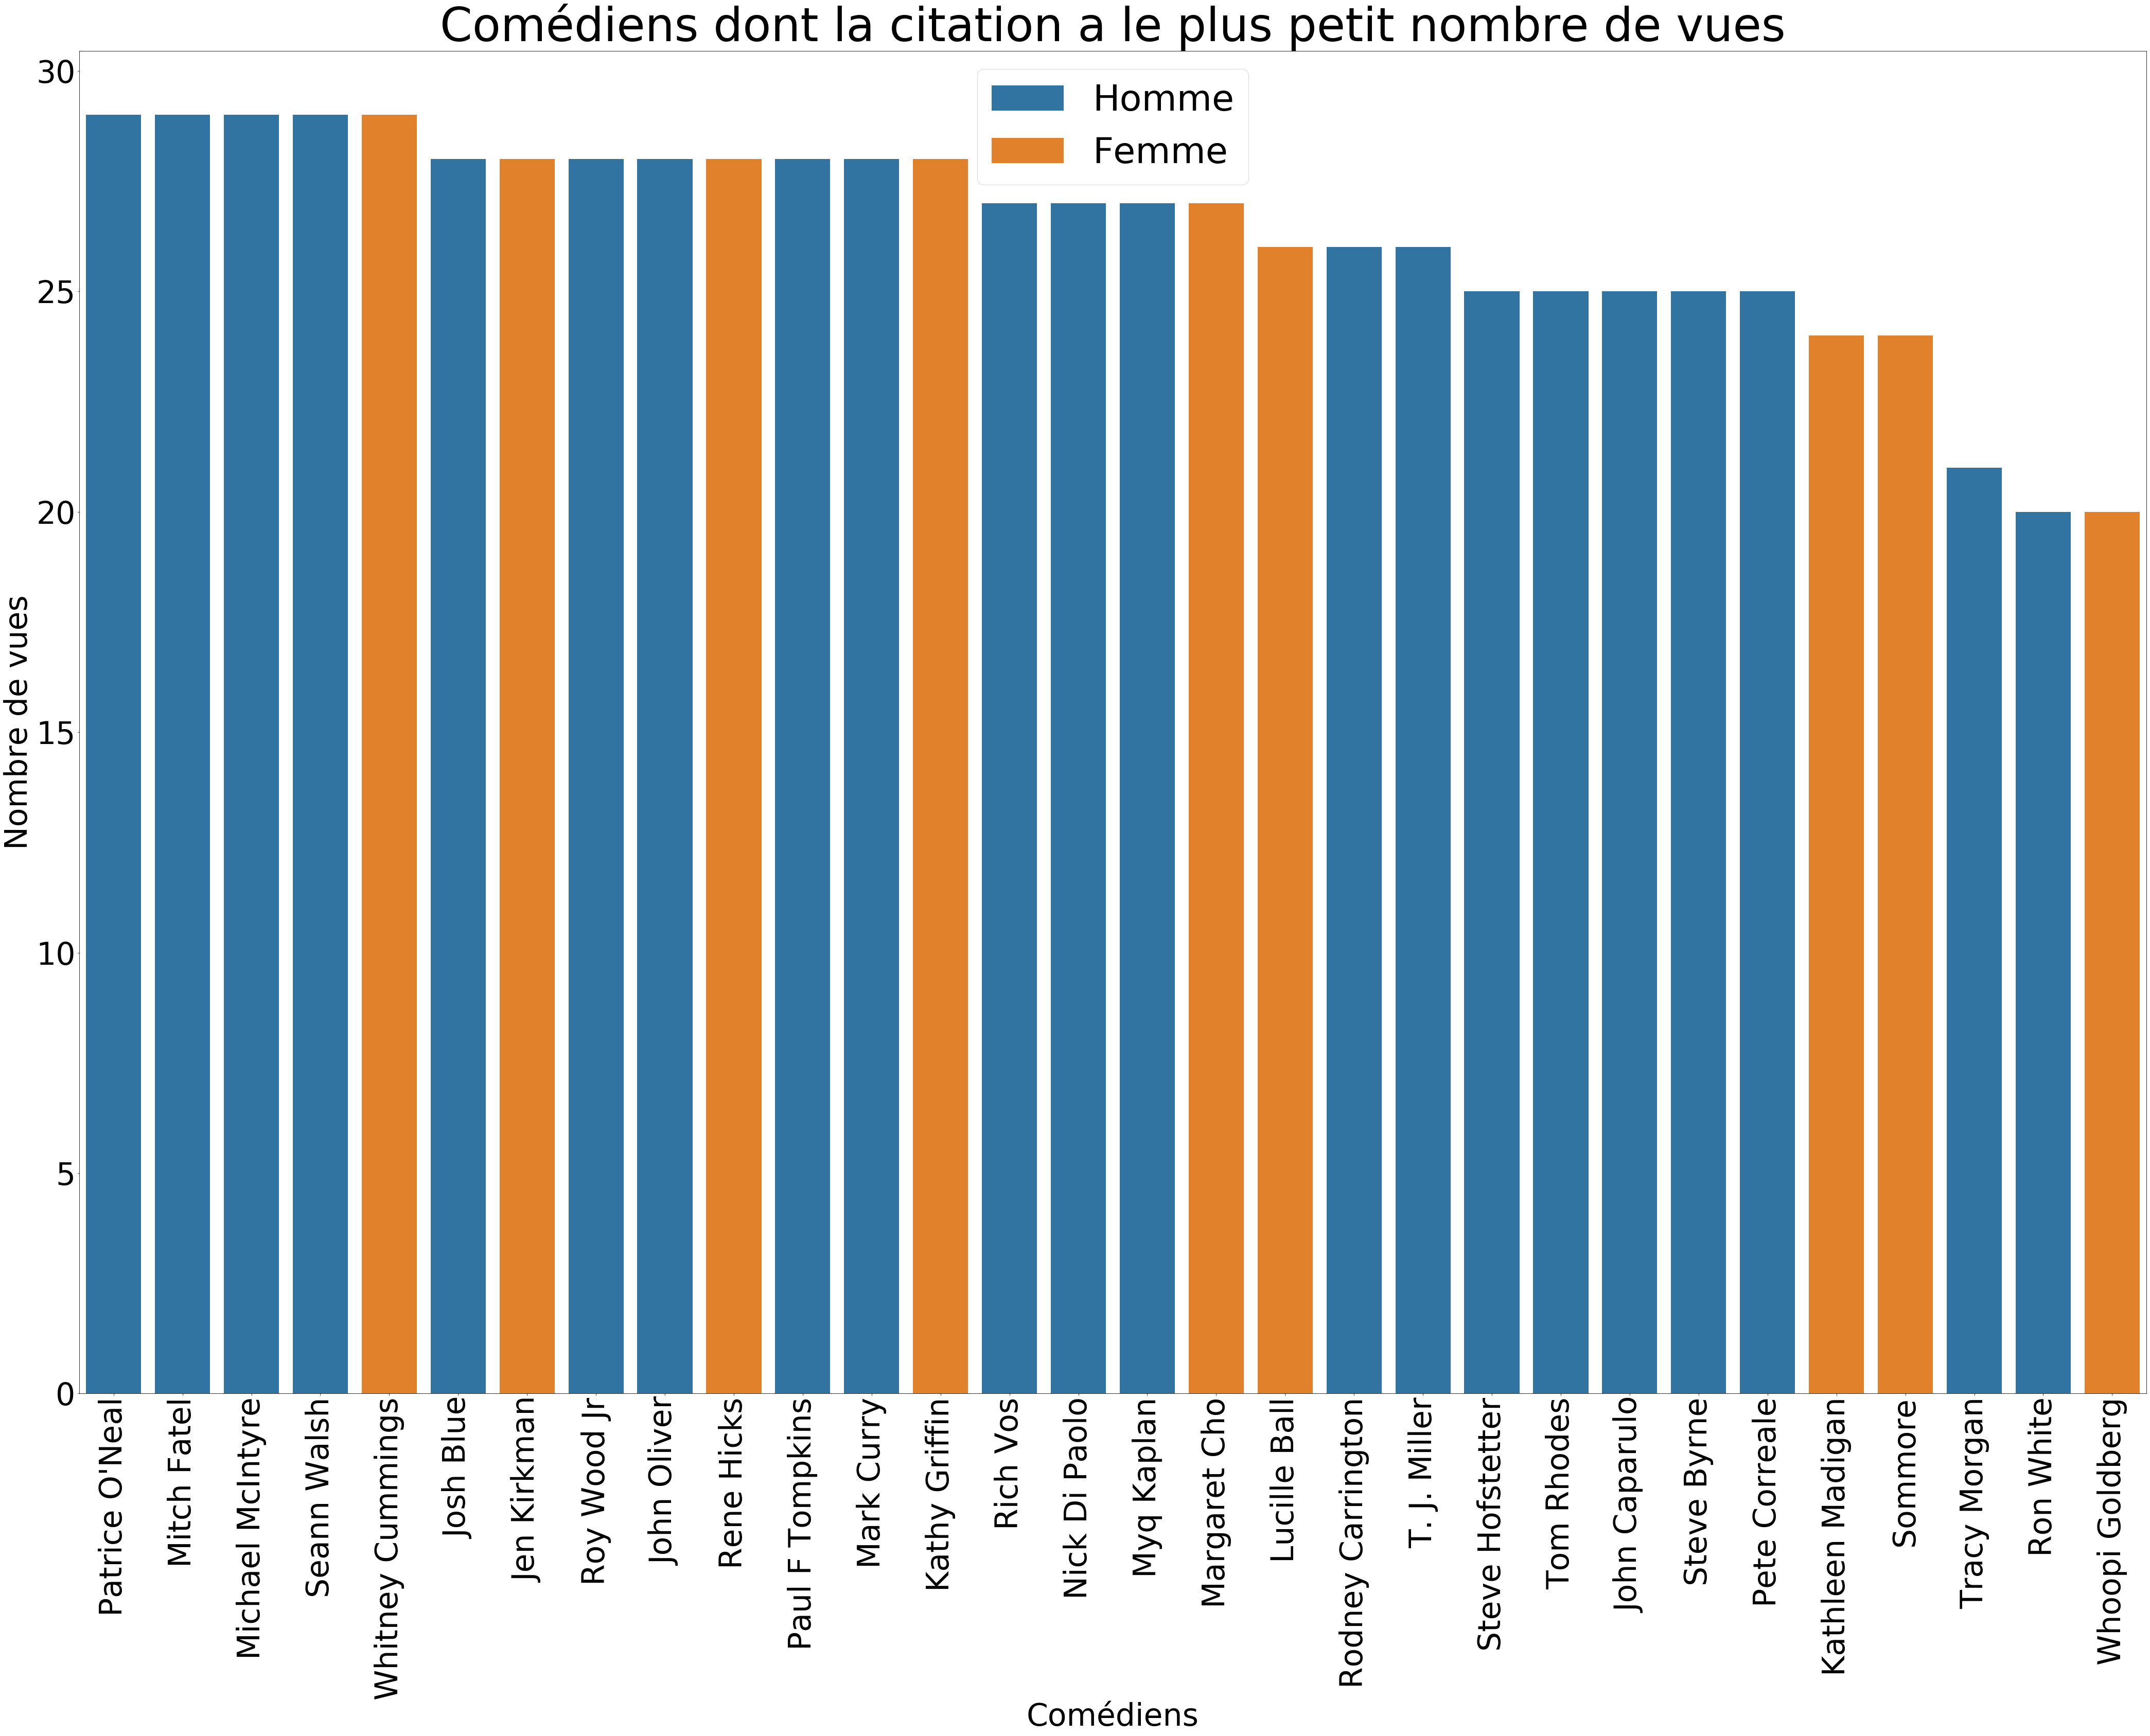

In [61]:
quote_df_auteur_min_nbre_vues = quote_df.loc[:,('auteur','nbre_vues','genre')]\
                                        .sort_values(by='nbre_vues',ascending=False)\
                                        .drop_duplicates(subset='auteur')\
                                        .tail(30)

plt.figure(figsize=(72,48))

sns.barplot(x='auteur',y='nbre_vues',data=quote_df_auteur_min_nbre_vues,hue="genre", dodge=False)
plt.title("Comédiens dont la citation a le plus petit nombre de vues", fontsize=90)
plt.xticks(rotation=90, fontsize=60)
plt.yticks(fontsize=60)

plt.xlabel('Comédiens', fontsize=60)
plt.ylabel('Nombre de vues', fontsize=60)
plt.legend(prop={"size":70})

plt.savefig("08.Flop30_comediens_par_citation_avec_nbre_vues.jpg", dpi=300)

#### <span style="color: #a40334"> Quel est l'humoriste qui le plus grand total de nombre de vues cumulées ?</span>

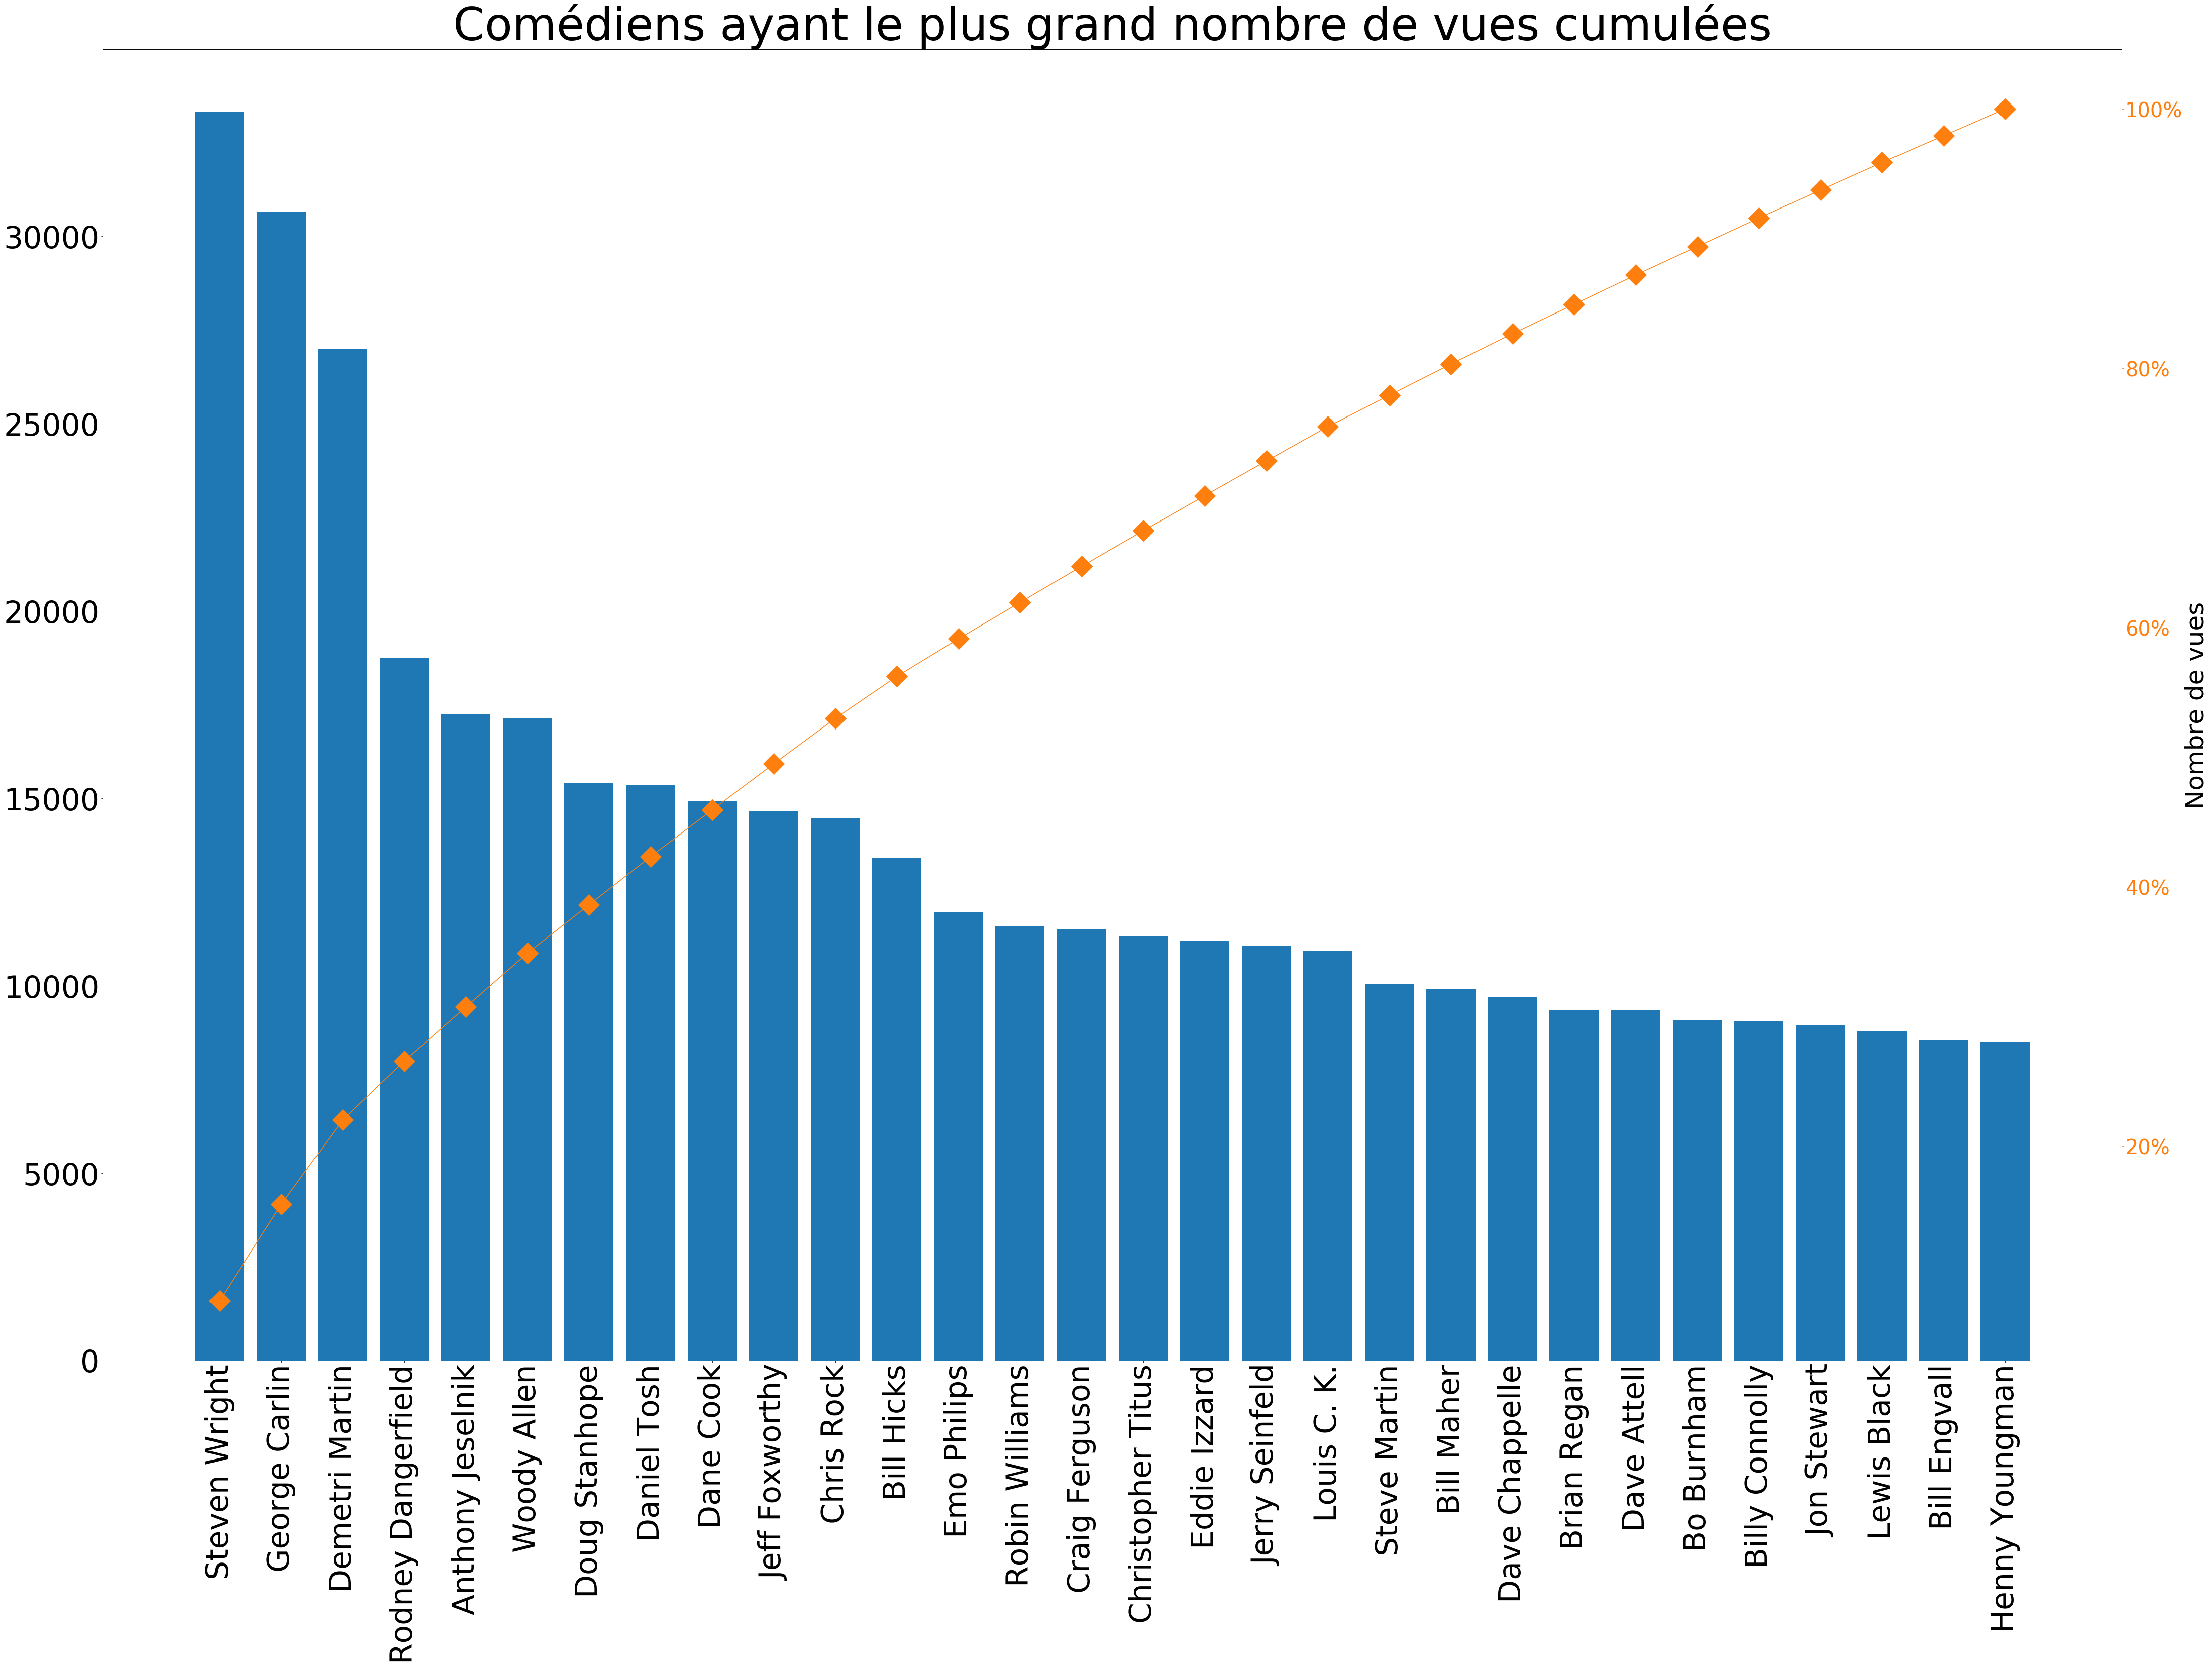

In [62]:
quote_df_auteur_max_nbre_vues_cumule = quote_df.loc[:,('auteur','nbre_vues','genre')]\
                                               .sort_values(by='nbre_vues',ascending=False)\
                                               .groupby(['auteur','genre']).sum().reset_index()\
                                               .sort_values('nbre_vues',ascending=False)\
                                               .head(30)

quote_df_auteur_max_nbre_vues_cumule.index = list(quote_df_auteur_max_nbre_vues_cumule.auteur)
quote_df_auteur_max_nbre_vues_cumule['cumpercentage'] = quote_df_auteur_max_nbre_vues_cumule['nbre_vues'].cumsum()/quote_df_auteur_max_nbre_vues_cumule['nbre_vues'].sum()*100


fig, ax = plt.subplots(figsize=(72,48))
plt.title("Comédiens ayant le plus grand nombre de vues cumulées", fontsize=90)
ax.bar(quote_df_auteur_max_nbre_vues_cumule.index, quote_df_auteur_max_nbre_vues_cumule['nbre_vues'], color="C0")
ax2 = ax.twinx()
ax2.plot(quote_df_auteur_max_nbre_vues_cumule.index, quote_df_auteur_max_nbre_vues_cumule['cumpercentage'], color="C1", marker="D", ms=30)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y")
ax2.tick_params(axis="y", colors="C1")

plt.xticks(rotation=90, fontsize=60)
plt.yticks(fontsize=40)

plt.xlabel('Comédiens', fontsize=60)
plt.ylabel('Nombre de vues', fontsize=50)

ax.tick_params(axis='x', which='major', labelsize=60,rotation=90)
ax.tick_params(axis='y', which='major', labelsize=60)
ax.tick_params(axis='both', which='minor', labelsize=60)

plt.savefig("09.Top30_comediens_par_nbre_vues_cumulees.jpg", dpi=300)

plt.show()

Ce classement est différent de celui sur le site, présentant le top 10 des comédiens (https://scomedy.com/) : 

1. Adam Sandler
2. Brett Butler
3. Anthony Jeselnik
4. Bill Hicks
5. Bobcat Goldthwait
6. Bonnie McFarlane
7. Daniel Tosh
8. Bill Burr
9. Ray Romano
10. Steven Wright

Les 22 premiers humoristes cumulent 80% des nombres de vues(jusqu'à Dave Chappelle).

In [104]:
quote_df_auteur_max_nbre_vues_cumule

auteur  genre  nbre_vues  cumpercentage
Steven Wright            Steven Wright  Homme      33324       8.066246
George Carlin            George Carlin  Homme      30666      15.489109
Demetri Martin          Demetri Martin  Homme      26982      22.020241
Rodney Dangerfield  Rodney Dangerfield  Homme      18742      26.556838
Anthony Jeselnik      Anthony Jeselnik  Homme      17236      30.728901
Woody Allen                Woody Allen  Homme      17150      34.880146
Doug Stanhope            Doug Stanhope  Homme      15403      38.608522
Daniel Tosh                Daniel Tosh  Homme      15352      42.324552
Dane Cook                    Dane Cook  Homme      14915      45.934805
Jeff Foxworthy          Jeff Foxworthy  Homme      14670      49.485754
Chris Rock                  Chris Rock  Homme      14471      52.988534
Bill Hicks                  Bill Hicks  Homme      13403      56.232799
Emo Philips                Emo Philips  Homme      11972      59.130683
Robin Williams          Robin Williams  Homme      11589      61.935860
Craig Ferguson          Craig Ferguson  Homme      11514      64.722883
Christopher Titus    Christopher Titus  Homme      11309      67.460285
Eddie Izzard              Eddie Izzard  Homme      11197      70.170576
Jerry Seinfeld          Jerry Seinfeld  Homme      11071      72.850369
Louis C. K.                Louis C. K.  Homme      10924      75.494579
Steve Martin              Steve Martin  Homme      10036      77.923845
Bill Maher                  Bill Maher  Homme       9920      80.325032
Dave Chappelle          Dave Chappelle  Homme       9692      82.671030
Brian Regan                Brian Regan  Homme       9345      84.933035
Dave Attell                Dave Attell  Homme       9342      87.194315
Bo Burnham                  Bo Burnham  Homme       9081      89.392417
Billy Connolly          Billy Connolly  Homme       9061      91.585679
Jon Stewart                Jon Stewart  Homme       8937      93.748926
Lewis Black                Lewis Black  Homme       8785      95.875380
Bill Engvall              Bill Engvall  Homme       8545      97.943742
Henny Youngman          Henny Youngman  Homme       8495     100.000000

In [107]:
quote_df_auteur_max_nbre_vues_Cumule = quote_df.loc[:,('auteur','nbre_vues','genre')]\
                                               .sort_values(by='nbre_vues',ascending=False)\
                                               .groupby(['auteur','genre']).sum().reset_index()\
                                               .sort_values('nbre_vues',ascending=False)\

quote_df_auteur_max_nbre_vues_Cumule['Pourcentage'] = round((quote_df_auteur_max_nbre_vues_Cumule['nbre_vues']/quote_df_auteur_max_nbre_vues_Cumule['nbre_vues'].sum())*100,2)

quote_df_auteur_max_nbre_vues_Cumule.head(10)

auteur  genre  nbre_vues  Pourcentage
267       Steven Wright  Homme      33324         3.76
116       George Carlin  Homme      30666         3.46
80       Demetri Martin  Homme      26982         3.04
244  Rodney Dangerfield  Homme      18742         2.11
17     Anthony Jeselnik  Homme      17236         1.94
288         Woody Allen  Homme      17150         1.93
89        Doug Stanhope  Homme      15403         1.74
68          Daniel Tosh  Homme      15352         1.73
67            Dane Cook  Homme      14915         1.68
139      Jeff Foxworthy  Homme      14670         1.65

#### <span style="color: #a40334"> Quel est l'humoriste qui le plus petit total de nombre de vues cumulées ?</span>

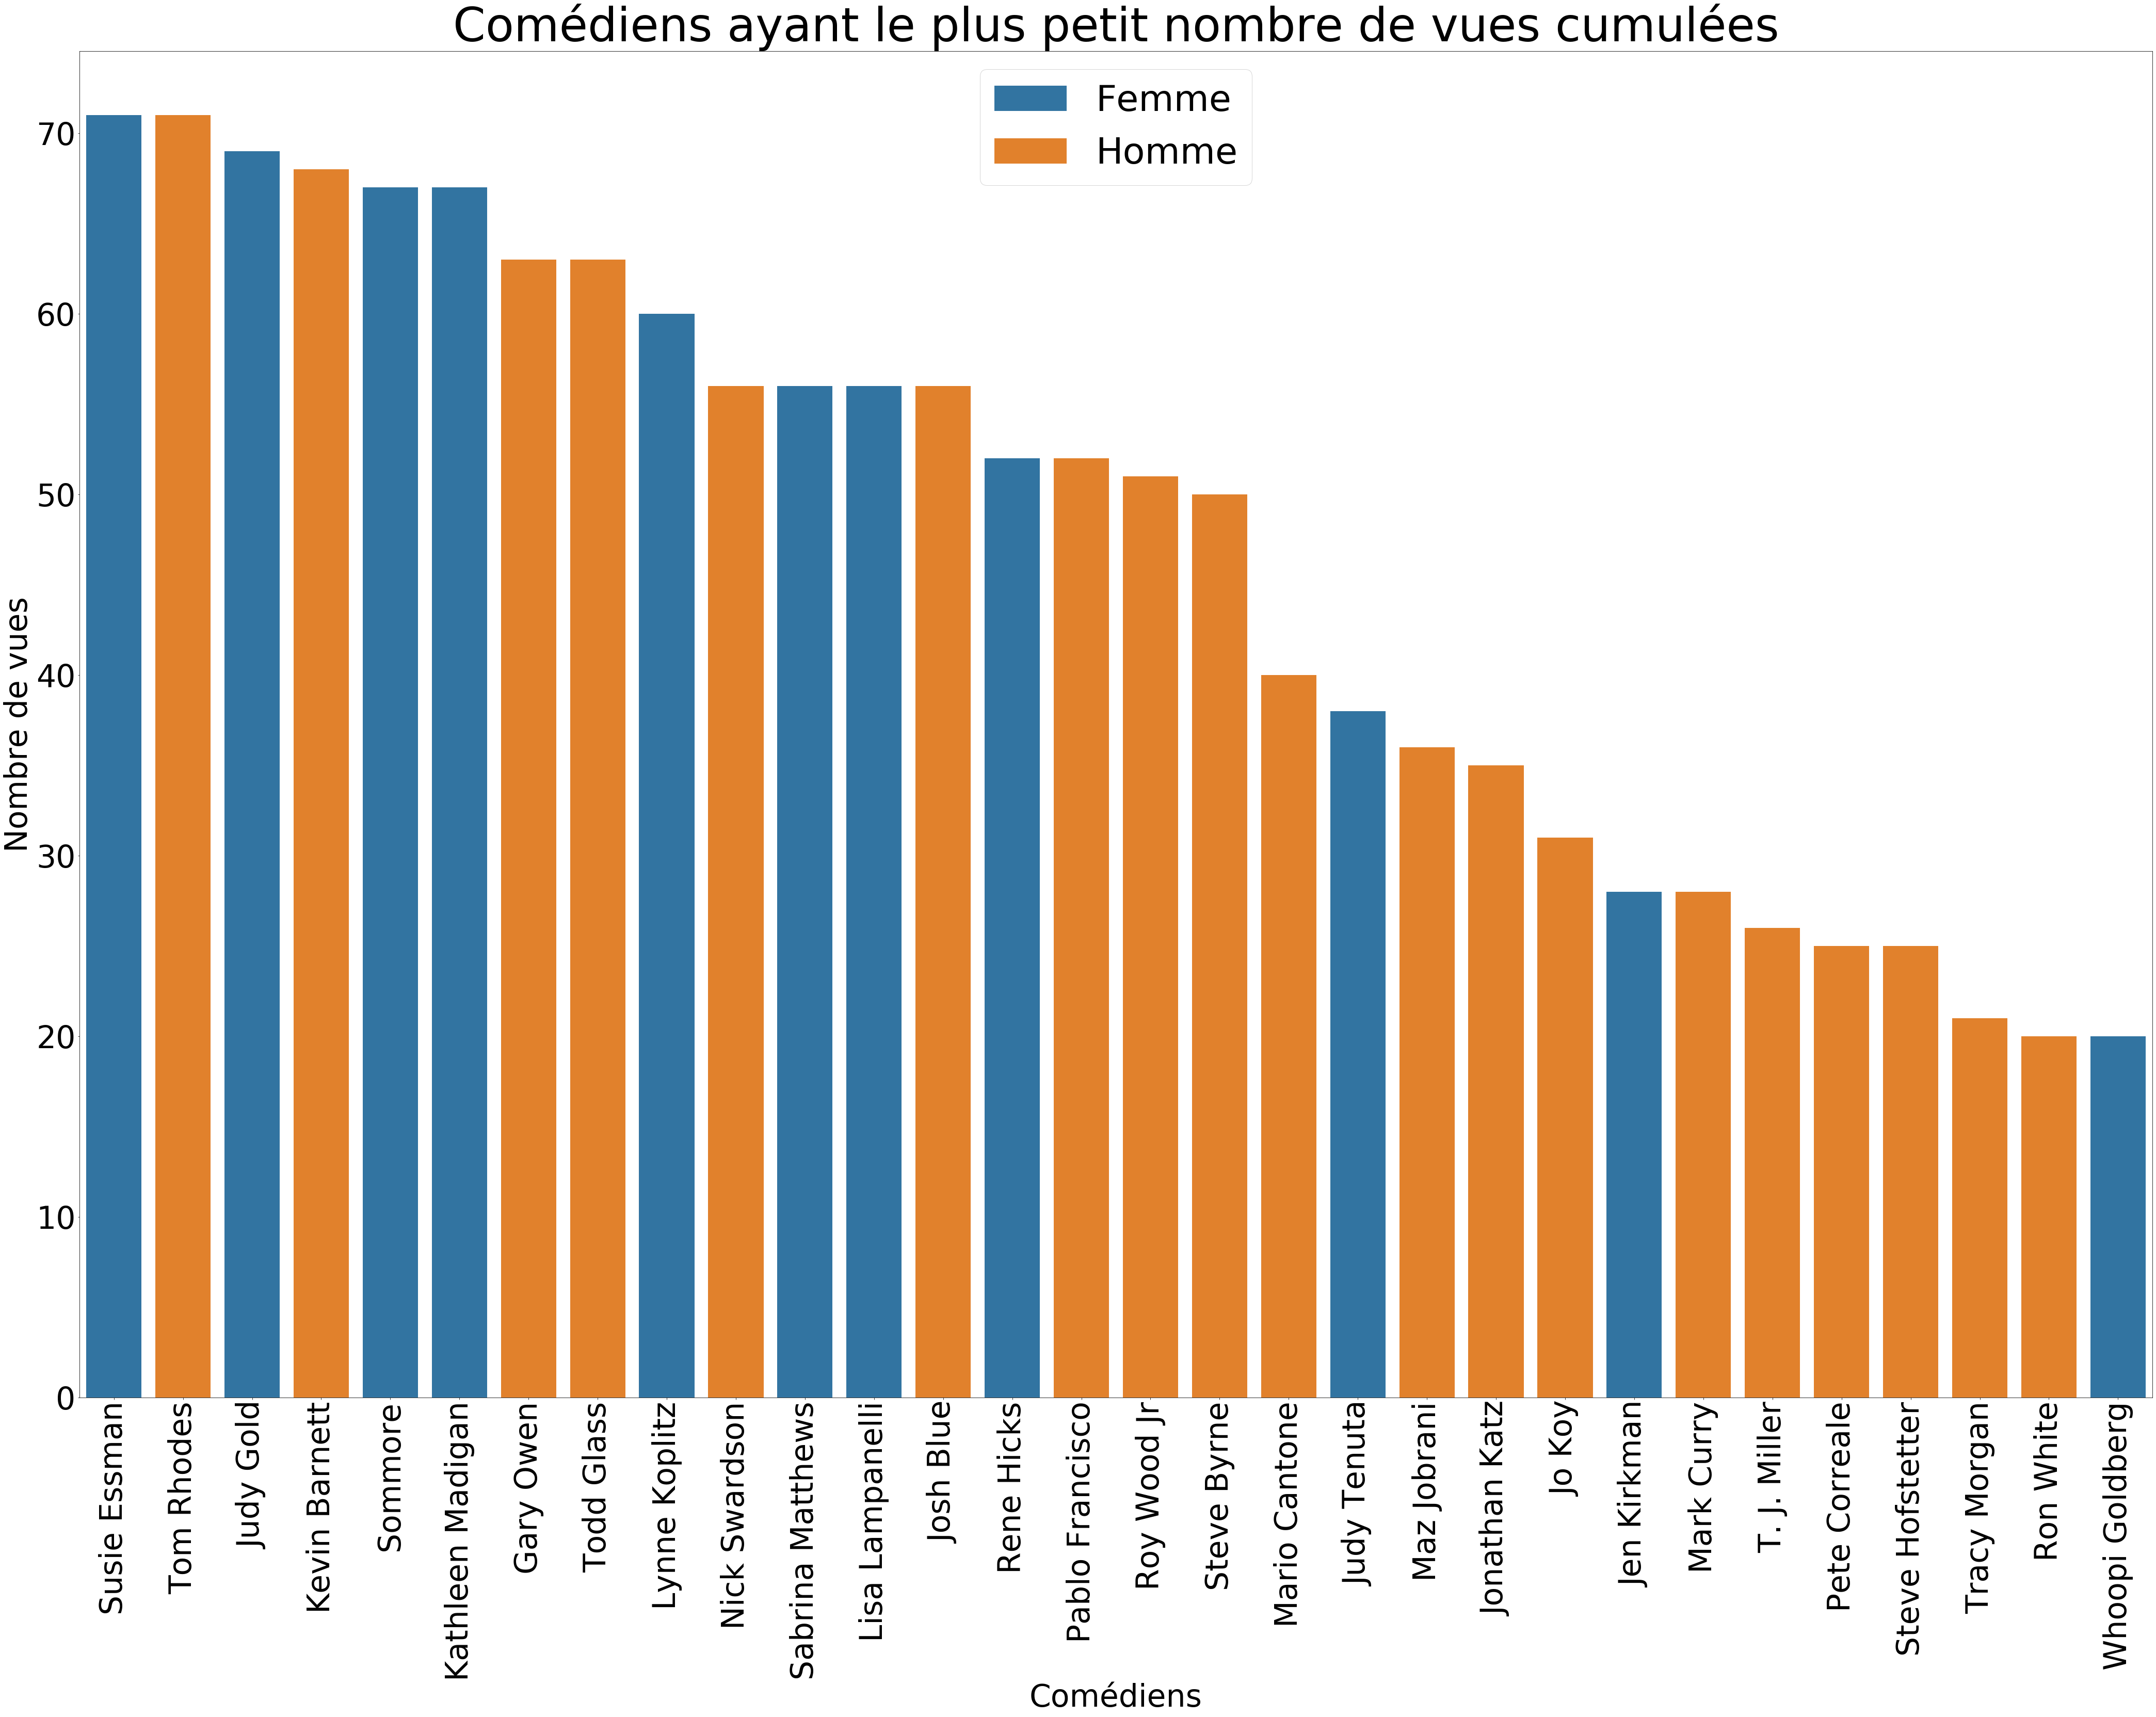

In [63]:
quote_df_auteur_min_nbre_vues_cumule = quote_df.loc[:,('auteur','nbre_vues','genre')]\
                                               .sort_values(by='nbre_vues',ascending=False)\
                                               .groupby(['auteur','genre']).sum().reset_index()\
                                               .sort_values('nbre_vues',ascending=False)\
                                               .tail(30)
    
plt.figure(figsize=(72,48))

sns.barplot(x='auteur',y='nbre_vues',data=quote_df_auteur_min_nbre_vues_cumule,hue="genre", dodge=False)
plt.title("Comédiens ayant le plus petit nombre de vues cumulées", fontsize=90)

plt.xticks(rotation=90, fontsize=60)
plt.yticks(fontsize=60)


plt.xlabel('Comédiens', fontsize=60)
plt.ylabel('Nombre de vues', fontsize=60)
plt.legend(prop={"size":70})

plt.savefig("10.Flop30_comediens_par_nbre_vues_cumulees.jpg", dpi=300)

### <span style="color: #030aa4">Quelles citations plaisent ?</span>

#### <span style="color: #a40334"> Quelles citations ont le plus de succès ?</span>

In [64]:
quote_df.sort_values(by='nbre_vues',ascending=False)\
        .head(50)

citation            auteur  \
0     Well, birthdays are merely symbolic of how ano...    Jerry Seinfeld   
39    My perfect date night: I pick you up. In my Ki...       Aziz Ansari   
5480  I mean, they don't grade fathers. But if your ...        Chris Rock   
5626  Jack and Jill went up the hill Both with a buc...  Andrew Dice Clay   
139   “Money doesn’t buy happiness.” Uh, do you live...       Daniel Tosh   
229   When I was a kid my parents used to tell me, "...       Emo Philips   
300   Rights aren't rights if someone can take them ...     George Carlin   
519   Then Jasper said "Look here, nigger, if anyone...    Dave Chappelle   
554   I have this friend who got divorced. I went go...       Brian Regan   
579   Mama says that, happiness is from magic rays o...      Adam Sandler   
602   My ex-girlfriend had a really weird fetish. Sh...        Bo Burnham   
6491       Bitch was so fine I'd suck her daddy's dick.     Richard Pryor   
670   I'll show you politics in America. Here it is,...        Bill Hicks   
64    Fellas, when you wake up in the morning, you s...        Chris Rock   
761   I was having sex with this girl. And we were t...     Donald Glover   
784   My girlfriend loves to eat chocolate. She’s al...  Anthony Jeselnik   
6235  I hate you. I hate you. I don’t even know you,...    Dave Chappelle   
908   Right, but yeah, you say things, but sometimes...         Dane Cook   
7029  One day I got on the usual bus, and when I ste...     Steven Wright   
5627  If it smells like fish its a dish. If it smell...  Andrew Dice Clay   
7527  Price check on Vagiclean, aisle five. I repeat...        Jim Carrey   
1151  What's the difference between a pickpocket and...         Redd Foxx   
6818  We had Monopoly, everybody did. No one liked i...         Dane Cook   
785   My mom, for most of her life, was a Holocaust ...  Anthony Jeselnik   
301   I have certain rules I live by. My first rule:...     George Carlin   
140   Anal sex is a lot like spinach: if you're forc...       Daniel Tosh   
909   Oh no, Mr. Kool-Aid Man, oh no! You better fix...         Dane Cook   
982   For my birthday I got a humidifier and a de-hu...     Steven Wright   
1161  Whatever cleaning goes on on the planet, women...    Jeff Foxworthy   
1362  You all have that friend who's quitting it. I ...       Denis Leary   
8025  I think vests are all about protection. You kn...    Demetri Martin   
8526  There’s 5 levels of fatness! Fluffy is one of ...  Gabriel Iglesias   
1258  “I heard this lady say “I love kids.” That’s n...    Demetri Martin   
7030  The other night I came home late, and tried to...     Steven Wright   
983   I’m addicted to placebos. I’d give them up, bu...     Steven Wright   
1430  Pol Pot killed one point seven million Cambodi...      Eddie Izzard   
1492  There's this critical point where you've staye...         Bill Burr   
8755  I will fuck a kid up. When a kid gets one-year...        Bernie Mac   
6428  Dick's and vagina's are like Coke and Pepsi, I...        Bo Burnham   
5628             Little Boy Blue - He needed the money.  Andrew Dice Clay   
1531  You know, a lot of people come to me and they ...      Steve Martin   
5481  I'm watching the news … Tupac Shakur was assas...        Chris Rock   
1259  I think it’s weird when you give someone flowe...    Demetri Martin   
6819  I always wanted to do a B&E. Not bacon and egg...         Dane Cook   
5332  I was the best man to a wedding one time, that...    Jerry Seinfeld   
302   You ever notice that? Any time you see two gro...     George Carlin   
1583  Marijuana is not a drug! I used to suck dick f...         Bob Saget   
640   I went to the White House, met the president.....     Richard Pryor   
762   Why don't women have crazy men stories? I don'...     Donald Glover   
5482  You know those guys that eat at the strip club...        Chris Rock   

      nbre_vues                          theme  genre          ethnie  \
0          1682                     [birthday]

#### <span style="color: #a40334"> Quelles citations ont le moins de succès ?</span>

In [65]:
quote_df.sort_values(by='nbre_vues',ascending=False)\
        .tail(50)

citation              auteur  \
16949  I would imagine the inside of a bottle of clea...       Mitch Hedberg   
16950  People teach their dogs to sit; it's a trick. ...       Mitch Hedberg   
16975     I'm an ice sculptor. Last night I made a cube.       Mitch Hedberg   
10452  I stopped drinking when I was 17 years old bec...   Christopher Titus   
6226                          “No comment” is a comment.       George Carlin   
12502  I went out with a guy the other night. He goes...     Chelsea Handler   
12501   First of all, i’m not an actor - I’m an asshole.     Chelsea Handler   
5620   Don't argue! You cannot win, you cannot beat a...          Chris Rock   
5621   Alcohol! Tastes great, I love it, you love it,...          Chris Rock   
8717   Guns don’t kill people, people kill people. An...        Eddie Izzard   
8718   Well, comedy is a great weapon of attack. It's...        Eddie Izzard   
16979  Last week I helped my friend stay put. It's a ...       Mitch Hedberg   
9711   The problem is that God gives men a brain and ...      Robin Williams   
8446   I was on the street. This guy waved to me, and...      Demetri Martin   
14175  One day they will invent a time machine and, l...          Dana Gould   
16978  There's a guy in the audience with a distincti...       Mitch Hedberg   
16977  I don't own a cell phone or a pager. I just ha...       Mitch Hedberg   
16976  I saw on HBO they were advertising a boxing ma...       Mitch Hedberg   
12861  I spend so much time alone that whenever I see...        Dov Davidoff   
8447   I'm in a weird position, because I like rainbo...      Demetri Martin   
8719   If you’re a transvestite, you’re actually a ma...        Eddie Izzard   
9979   Last night my wife met me at the front door. S...  Rodney Dangerfield   
9713   When I was growing up they used to say, "Robin...      Robin Williams   
8023   Did you know babies are nauseated by the smell...      Jeff Foxworthy   
5622   You don’t need no gun control. We need some bu...          Chris Rock   
10244  My ex-wife claimed she was violated. Knowing m...         Woody Allen   
9712   Beer commercials usually show big men, manly m...      Robin Williams   
5623   I got bused to school into a poor white neighb...          Chris Rock   
13110  I have a dog, a lovely animal… I’m feeding him...     David Letterman   
5624   They're working their way down. Next year, Tod...          Chris Rock   
12862  Few things are as uniquely painful as bad come...        Dov Davidoff   
7022   I say “God bless you” when somebody sneezes. I...           Dane Cook   
8720   We hate our national anthem. Because it’s “God...        Eddie Izzard   
8448   I noticed that there are no B batteries. I thi...      Demetri Martin   
5625   When I heard they were trying and get rid of t...          Chris Rock   
8449   I like video games, but they're really violent...      Demetri Martin   
7023   [talking about movie dates and how guys can ne...           Dane Cook   
8450   I like women, but you can't always trust them....      Demetri Martin   
8451   When someone asks you the question 'Are you ti...      Demetri Martin   
8455   I bought a dictionary. First thing I did was, ...      Demetri Martin   
10247  My father worked for the same firm for twelve ...         Woody Allen   
8454   I saw a door that said exit only. So I entered...      Demetri Martin   
10246  I was gonna kill myself, but I was in a strict...         Woody Allen   
8452   A couple weeks ago I was on the street and I s...      Demetri Martin   
8456   I was seeing this girl and she wanted to get m...      Demetri Martin   
8453   Whenever I see an autobiography for sale in th...      Demetri Martin   
9716   I went to rehab [for alcoholism] in wine count...      Robin Williams   
9715   I wonder what chairs think about all day: "Oh,...      Robin Williams   
9714   The Second Amendment! It says you have the rig...      Robin Williams   
10245  The phone rings, and a voice on the other

#### <span style="color: #a40334"> Quels mots aparaissent le plus dans les citations ?</span>

In [66]:
text=quote_df.theme

#set the stopwords list
stopwords= set(STOPWORDS)
#append new words to the stopwords list
stopwords.update(['english'])


### Stopwords ne fonctionne pas
### Des mots comme think , things apparaissent encore
### Vérifier si différenciation lettre en majuscule /minuscule


wc = WordCloud(background_color="white", 
               max_words=2000, 
               min_font_size =15, 
               max_font_size=40, 
               relative_scaling = 0.5, 
               stopwords=stopwords,
               normalize_plurals= True)


wc.generate(' '.join(text))

plt.figure(figsize=(25,25))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

#Show the wordcloud
plt.show()

TypeError: sequence item 0: expected str instance, list found

### <span style="color: #030aa4">Est-il possible de rire de tout ?</span>

In [76]:
quote_df.groupby('ethnie').count()

citation  auteur  nbre_vues  theme  genre  religion  \
ethnie                                                                   
afro-americain         1830    1830       1830   1830   1830      1830   
americano-iranien         1       1          1      1      1         1   
asiatique                54      54         54     54     54        54   
banc                     43      43         43     43     43        43   
blanc                 16068   16068      16068  16068  16068     16068   
hispanique              352     352        352    352    352       352   
indo-americain          157     157        157    157    157       157   
italo-americain         160     160        160    160    160       160   
russo-americain          91      91         91     91     91        91   

                   date_naissance  vivant  orientation_sexuelle  \
ethnie                                                            
afro-americain               1830    1830                  1830   
americano-iranien               1       1                     1   
asiatique                      54      54                    54   
banc                           43      43                    43   
blanc                       16068   16068                 16068   
hispanique                    352     352                   352   
indo-americain                157     157                   157   
italo-americain               160     160                   160   
russo-americain                91      91                    91   

                   annee_naissance  
ethnie                              
afro-americain                1830  
americano-iranien                1  
asiatique                       54  
banc                            43  
blanc                        16068  
hispanique                     352  
indo-americain                 157  
italo-americain                160  
russo-americain                 91

In [86]:
Auteurs_df=Auteurs_df.replace({'ethnie':'banc'},{'ethnie':'blanc'})

Prop_Auteurs = Auteurs_df.groupby('ethnie').count()

Prop_Auteurs = Prop_Auteurs.drop(columns=['genre','religion','vivant','date_naissance','orientation_sexuelle'])

Prop_Auteurs['Pourcentage']= round((Prop_Auteurs['auteur']/(Prop_Auteurs['auteur'].sum()))*100,2)

Prop_Auteurs = Prop_Auteurs.sort_values(by='Pourcentage',ascending = False)

Prop_Auteurs

auteur  Pourcentage
ethnie                                
blanc                 224        76.98
afro-americain         48        16.49
hispanique              7         2.41
asiatique               4         1.37
indo-americain          3         1.03
italo-americain         3         1.03
americano-iranien       1         0.34
russo-americain         1         0.34

In [90]:
Auteurs_df[Auteurs_df.auteur=='Steven Wright']

auteur  genre ethnie religion date_naissance vivant  \
267  Steven Wright  Homme  blanc    athee     06-12-1955    Oui   

    orientation_sexuelle  
267         heterosexuel

In [101]:
quote_df[quote_df.auteur=='Steven Wright'].head(60)

citation         auteur  \
982   For my birthday I got a humidifier and a de-hu...  Steven Wright   
983   I’m addicted to placebos. I’d give them up, bu...  Steven Wright   
984   Hard work pays off in the future. Laziness pay...  Steven Wright   
985   I named my dog Stay, so I can say, 'Come here,...  Steven Wright   
986   Many people quit looking for work when they fi...  Steven Wright   
987   I want to get a tattoo of myself on my entire ...  Steven Wright   
988   A friend of mine has a trophy wife, but appare...  Steven Wright   
989    I spilled spot remover on my dog. Now he's gone.  Steven Wright   
990   I took my dog for a walk, all the way from New...  Steven Wright   
991   I got a new dog. He's a paranoid retriever. He...  Steven Wright   
992   I’m going to court next week I’ve been selecte...  Steven Wright   
993   If you must choose between two evils, pick the...  Steven Wright   
994   I don’t know how she did it, but Rachel got po...  Steven Wright   
995   The ice cream truck in my neighborhood plays "...  Steven Wright   
996   One time I went to a museum where all the work...  Steven Wright   
997   I saw a sign at a gas station. It said 'help w...  Steven Wright   
998   There's a fine line between fishing and just s...  Steven Wright   
999   Sometimes I talk to myself fluently in languag...  Steven Wright   
1000  My house is made out of balsa wood, so when I ...  Steven Wright   
1001  I remember when the candle shop burned down. E...  Steven Wright   
1002  I still have my Christmas Tree. I looked at it...  Steven Wright   
1003  I put instant coffee in a microwave oven and a...  Steven Wright   
1004  Last night, I was in a restaurant called Bulim...  Steven Wright   
1005  If it's a penny for your thoughts and you put ...  Steven Wright   
1006  Last year I went fishing with Salvador Dali. H...  Steven Wright   
1007  Drugs may lead to nowhere, but at least it's t...  Steven Wright   
1008                  I'd kill for a Nobel Peace Prize.  Steven Wright   
1009  I can't wait to be arrested and go all the way...  Steven Wright   
1010  They say the universe is expanding. That shoul...  Steven Wright   
1011  It's a good apartment because they allow pets....  Steven Wright   
1012  Dancing is a perpendicular expression of a hor...  Steven Wright   
1013  Babies don't need a vacation, but I still see ...  Steven Wright   
1014  Ambition is a poor excuse for not having enoug...  Steven Wright   
1015                 My dog is an East German Shepherd.  Steven Wright   
1016  I like to go to art museums and name the untit...  Steven Wright   
1017  I just got out of the hospital. I was in a spe...  Steven Wright   
1018  I'm addicted to placebos. I could quit, but it...  Steven Wright   
1019  When I was 8, I played little league. I was on...  Steven Wright   
1020  If you want the rainbow, you got to put up wit...  Steven Wright   
1021  Why doesn't the fattest man in the world becom...  Steven Wright   
1022  In Vegas, I got into a long argument with the ...  Steven Wright   
1023  I had a dream that all the babies prevented by...  Steven Wright   
1024  Experience is something you don't get until ju...  Steven Wright   
1025  I was cleaning out my closet and I found a swi...  Steven Wright   
1026  If warm air rises, Heaven could be hotter than...  Steven Wright   
1027    I poured spot remover on my dog. Now he's gone.  Steven Wright   
1028  That's a good thing to say to the police the n...  Steven Wright   
1029  If life was fair, Elvis would be alive, and al...  Steven Wright   
1030  I bought my brother some gift-wrap for Christm...  Steven Wright   
1031  Why doesn’t the fattest man in the world becom...  Steven Wright   
1032  For my sister's 50th birthday, I sent her a si...  Steven Wright   
1033  Change is inevitable... except from vending ma...  Steven Wright   
1034                     Beware of geeks bearing gifts.  Steven Wright   
1035  Since Americans throw rice at weddings, do As

In [103]:
quote_df.citation[985]

"I named my dog Stay, so I can say, 'Come here, Stay! Come here, Stay!'"

In [91]:
Auteurs_df[Auteurs_df.auteur=='Demetri Martin']

auteur  genre ethnie religion date_naissance vivant  \
80  Demetri Martin  Homme  blanc    athee     25-05-1973    Oui   

   orientation_sexuelle  
80         heterosexuel

In [92]:
Auteurs_df[Auteurs_df.auteur=='George Carlin']

auteur  genre ethnie religion date_naissance vivant  \
116  George Carlin  Homme  blanc    athee     12-05-1937    Non   

    orientation_sexuelle  
116         heterosexuel

In [97]:
TopAuteur = quote_df.groupby('auteur')['citation'].count().reset_index()

TopAuteur = TopAuteur.sort_values(by='citation',ascending=False)

TopAuteur

auteur  citation
267       Steven Wright       617
80       Demetri Martin       537
116       George Carlin       504
139      Jeff Foxworthy       460
244  Rodney Dangerfield       410
..                  ...       ...
193          Mark Curry         1
265    Steve Hofstetter         1
196         Maz Jobrani         1
166         Judy Tenuta         1
245           Ron White         1

[291 rows x 2 columns]

In [99]:
ThemeAuteur = quote_df.groupby('auteur','theme').count().reset_index()

ThemeAuteur


ValueError: No axis named theme for object type <class 'pandas.core.frame.DataFrame'>

In [116]:
ArtistesNonHetero =quote_df[quote_df.orientation_sexuelle!='heterosexuel']

ArtistesNonHetero.theme.explode().unique()

array(['hitler', 'pope', 'toasters', 'football', 'coffee', 'smoking',
       'racism', 'new york', 'kids', 'school', 'men', 'shoes',
       'dinosaurs', 'animals', 'baseball', 'arguments', 'emotions',
       'talent', 'differences', 'holocaust', 'money', 'dreams', 'dogs',
       'judgment', 'music', 'religion', 'philosophy', 'hollywood',
       'driving', 'cars', 'immigration', 'language', 'brain', 'army',
       'women', 'embarrassment', 'soul', 'swimming', 'life', 'government',
       'restaurants', 'comedians', 'holidays', 'intelligence', 'success',
       'challenges', 'truth', 'happiness', 'honesty', 'stuff',
       'confidence', 'change', 'decisions', 'birthday', 'celebrities',
       'acceptance', 'beat', 'nowdays', 'advertising', 'basketball',
       'waitresses', 'christmas', 'patients', 'terrorists', 'care',
       'politics', 'aggression', 'friends', 'problems', 'gays', 'work',
       'love', 'golf', 'help', 'audience', 'dancing', 'rage', 'democracy',
       'white house', '

In [119]:
len(quote_df[quote_df.theme=='gay'])

29

In [120]:
quote_df[quote_df.theme=='gay']

citation              auteur  \
5555   Gay people got a right to be as miserable as e...          Chris Rock   
6489   I’m gay for Jesus, fill me with your grace. Po...          Bo Burnham   
9745   I went to a gay bar, they wanted proof of sex ...  Rodney Dangerfield   
10000  I'm not gay, so I don't know much about Broadw...      Norm Macdonald   
10708  You're thinking I'm homophobic; I hear it all ...         Dave Attell   
10756  I'm sorry, was that homophobic? No--I think it...         Dave Attell   
10767  You’re thinking I’m homophobic; I hear it all ...         Dave Attell   
11286  I'm not a gay man, but I will say this: I get ...         Kevin James   
11465  If you join a gym, you gotta go a lot for it t...        Greg Giraldo   
12075  If you're going to be a romantic idol and try ...         Joan Rivers   
12423               He's as gay as a candle in the wind.     Chelsea Handler   
12432  It's hard on an all-gay softball team because ...     Chelsea Handler   
12684  I'm passionate about gay rights, but I think w...        Dov Davidoff   
13461  The Kinsey Institute says gay men have bigger ...            Jay Leno   
13646  Bush proposed a constitutional amendment to ba...         Jon Stewart   
13655  What is the fear of the 'gay agenda' that has ...         Jon Stewart   
13942  Women look at my brother because he's hot, and...      Felipe Esparza   
15460  Gay Republicans, how exactly does that work? '...    Paula Poundstone   
15913  My kind of gay, meeting a woman and falling in...        Carol Leifer   
15922  My kind of gay is like the late-breaking-lesbi...        Carol Leifer   
15966  I'm so gay, I could put a lisp in the word 'cr...                 Ant   
16238  Gay pride's beautiful. If somebody needs to be...     Sandra Bernhard   
16263  Gay men, if they've been straight and turn gay...     Sandra Bernhard   
16317  My son I worry about. I'm pretty sure he's gon...        Adam Carolla   
16647  I want to see gay couples stuck with their sig...    David Alan Grier   
17584  You can't just go gay, its not like buying a l...       Noel Fielding   
17628  Every gay guys GPS system would tell him to Go...        Will Ferrell   
17944  I say no to gay marriage. It'll end up leading...          Jimmy Carr   
18393  I got a gay roommate. I got ground rules. I’m ...      Mike Birbiglia   

       nbre_vues theme  genre           ethnie religion date_naissance vivant  \
5555          22   gay  Homme   afro-americain    athee     1965-02-07    Oui   
6489          26   gay  Homme            blanc    athee     1990-08-21    Oui   
9745          76   gay  Homme            blanc    athee     1921-11-22    Non   
10000         51   gay  Homme            blanc    athee     1959-10-17    Oui   
10708        258   gay  Homme            blanc     juif     1965-01-18    Oui   
10756         35   gay  Homme            blanc     juif     1965-01-18    Oui   
10767         31   gay  Homme            blanc     juif     1965-01-18    Oui   
11286         48   gay  Homme            blanc    athee     1965-04-26    Oui   
11465        116   gay  Homme            blanc    athee     1965-12-10    Non   
12075         17   gay  Femme            blanc     juif     1933-06-08    Non   
12423         17   gay  Femme            blanc    athee     1975-02-25    Oui   
12432         15   gay  Femme            blanc    athee     1975-02-25    Oui   
12684         27   gay  Homme            blanc    athee     1973-09-22    Oui   
13461         19   gay  Homme            blanc    athee     1950-04-28    Oui   
13646         11   gay  Homme            blanc     juif     1962-11-28    Oui   
13655          9   gay  Homme            blanc     juif     1962-11-28    Oui   
13942         86   gay  Homme       hispanique    athee     1976-06-11    Oui   
15460         66   gay  Femme            blanc    athee     1959-12-29    Oui   
15913         32   gay  Femme            blanc    athee     1956-07-27    Oui   
15922         29   gay  Fem

In [121]:
quote_df[quote_df.theme=='racism']

citation         auteur  \
17743  You ever see those racism public service annou...  Ted Alexandro   

       nbre_vues   theme  genre ethnie religion date_naissance vivant  \
17743         36  racism  Homme  blanc    athee     1969-01-26    Oui   

      orientation_sexuelle  annee_naissance  
17743         heterosexuel             1969

In [123]:
quote_df[quote_df.theme=='jews']

citation           auteur  \
10702  Jews are the best dressers in the world. They ...     Jackie Mason   
11520  Look at the insane things the Jews believe. Th...     Greg Giraldo   
12171  Why don't Jews drink? It interferes with their...   Henny Youngman   
13555  Reform Jews are the children of Conservative J...      Jon Stewart   
13700  Jews don't drink much because it interferes wi...     Milton Berle   
16597  Everyone knows that Jews control the media and...    Eugene Mirman   
16653  Jews don’t daydream. ‘Cause folks are after th...     John Mulaney   
16685  People go like 'Jews are cheap' *indian accent...   Russell Peters   
18316  Everybody blames the Jews for killing Christ, ...  Sarah Silverman   

       nbre_vues theme  genre           ethnie religion date_naissance vivant  \
10702         36  jews  Homme            blanc     juif     1936-06-09    Oui   
11520         26  jews  Homme            blanc    athee     1965-12-10    Non   
12171         30  jews  Homme            blanc    athee     1906-03-16    Non   
13555         22  jews  Homme            blanc     juif     1962-11-28    Oui   
13700         34  jews  Homme            blanc     juif     1908-07-12    Non   
16597         31  jews  Homme  russo-americain    athee     1974-07-24    Oui   
16653         24  jews  Homme            blanc    athee     1982-08-26    Oui   
16685         23  jews  Homme   indo-americain    athee     1970-09-29    Oui   
18316         30  jews  Femme            blanc    athee     1970-12-01    Oui   

      orientation_sexuelle  annee_naissance  
10702         heterosexuel             1936  
11520         heterosexuel             1965  
12171         heterosexuel             1906  
13555         heterosexuel             1962  
13700         heterosexuel             1908  
16597         heterosexuel             1974  
16653         heterosexuel             1982  
16685         heterosexuel             1970  
18316         heterosexuel             1970

In [130]:
quote_df[quote_df.theme=='jews']

Empty DataFrame
Columns: [citation, auteur, nbre_vues, theme, genre, ethnie, religion, date_naissance, vivant, orientation_sexuelle, annee_naissance]
Index: []

In [134]:
ArtistesNoirs = quote_df[quote_df.theme=='black']

ArtistesNoirs = ArtistesNoirs.groupby('ethnie').count()

ArtistesNoirs

citation  auteur  nbre_vues  theme  genre  religion  \
ethnie                                                                
afro-americain        26      26         26     26     26        26   
blanc                 22      22         22     22     22        22   

                date_naissance  vivant  orientation_sexuelle  annee_naissance  
ethnie                                                                         
afro-americain              26      26                    26               26  
blanc                       22      22                    22               22